## Baseline

#### Import Library

In [1]:
# !pip install statsmodels

In [2]:
# !pip install scikit-learn

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import platform
from statsmodels.tsa.seasonal import seasonal_decompose # ** 왜 모듈을 못 불러올까요...
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import random

from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import LabelEncoder

from sklearn.cluster import KMeans

import statsmodels.api as sm # ** 모듈 로드가 안되네요...

from datetime import datetime

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# 한글 폰트 설정
if platform.system() == 'Darwin':
    plt.rc('font', family = 'AppleGothic')
else :
    plt.rc('font', family = 'Malgun Gothic')

np.set_printoptions(precision=6, suppress=True)
 
pd.options.display.float_format = '{:.5f}'.format
pd.reset_option('display.float_format')

#### Data Load

In [4]:
customer = pd.read_csv('./data_in/customers.csv')
location = pd.read_csv('./data_in/locations.csv')
order_items = pd.read_csv('./data_in/order_items.csv')
orders = pd.read_csv('./data_in/orders.csv')
payments = pd.read_csv('./data_in/payments.csv')
product = pd.read_csv('./data_in/products.csv')
review = pd.read_csv('./data_in/reviews.csv')
seller = pd.read_csv('./data_in/sellers.csv')

In [5]:
# 데이터 작업을 위해 대부분의 데이터를 포함하는 total_df 생성

data_sum = pd.merge(order_items, orders, on= 'Order_id', how= 'left')

data_sum = pd.merge(data_sum, payments, on= 'Order_id', how= 'left')

data_sum = pd.merge(data_sum, product,  on= 'Product_id', how= 'left')

data_sum = pd.merge(data_sum, seller, on= 'Seller_id', how= 'left')

data_sum = pd.merge(data_sum, customer, on= 'Customer_id', how= 'left')

data_sum = pd.merge(data_sum, review, on= 'Order_id', how= 'left')

data_sum.to_csv('./data_in/total_df.csv', index= False)

total_df = pd.read_csv('./data_in/total_df.csv')

items_per_order = total_df.groupby('Order_id')['Order_item_id'].max().rename('Items_per_order')
total_df = total_df.join(items_per_order, on='Order_id')

total_df['Revenue'] = total_df['Price'] * total_df['Items_per_order']

total_df.to_csv('./data_in/total_df.csv', index= False)

total_df = pd.read_csv('./data_in/total_df.csv')

C:\Users\USER\AppData\Local\Temp\ipykernel_15228\275389554.py:17: DtypeWarning: Columns (17,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  total_df = pd.read_csv('./data_in/total_df.csv')
C:\Users\USER\AppData\Local\Temp\ipykernel_15228\275389554.py:26: DtypeWarning: Columns (17,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  total_df = pd.read_csv('./data_in/total_df.csv')


### EDA (탐색적 데이터 분석)

#### Top10 제품 카테고리 시각화

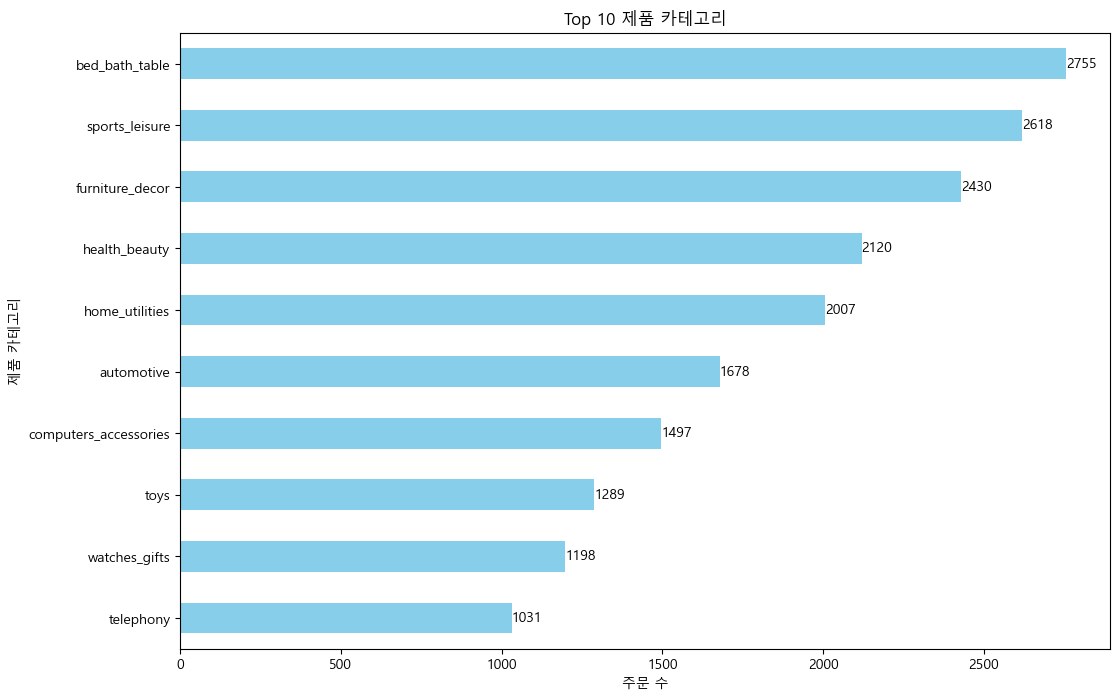

In [6]:
# 카테고리별 주문 수 계산
category_cnt = product['Product_category_name'].value_counts().head(10)

plt.figure(figsize=(12, 8))
bars = category_cnt.sort_values(ascending=True).plot(kind='barh', color='skyblue')

plt.title('Top 10 제품 카테고리')
plt.xlabel('주문 수')
plt.ylabel('제품 카테고리')

# 각 바 위에 값 표시
for bar in bars.containers[0]:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2,
             f'{int(bar.get_width())}', va='center')

plt.show()

#### 고객 Top 10 도시 시각화

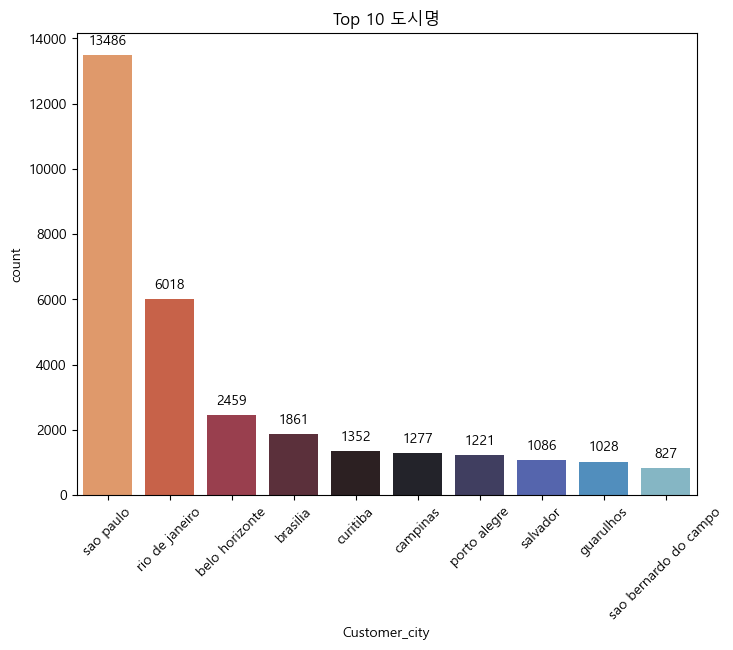

In [7]:
# 상위 10개 도시 선택
top10_cities = customer['Customer_city'].value_counts().head(10).index

# 상위 10개 도시에 대한 데이터만 필터링
data = customer[customer['Customer_city'].isin(top10_cities)]

# 시각화
plt.figure(figsize=(8,6))
ax = sns.countplot(x='Customer_city', data=data,
                   order=data['Customer_city'].value_counts().index, 
                   palette='icefire_r')

plt.title('Top 10 도시명')
plt.xticks(rotation=45) # 도시 이름이 긴 경우를 위해 x축 라벨 회전

# 각 바 위에 값 표시
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')

plt.show()


#### 지불형태 시각화

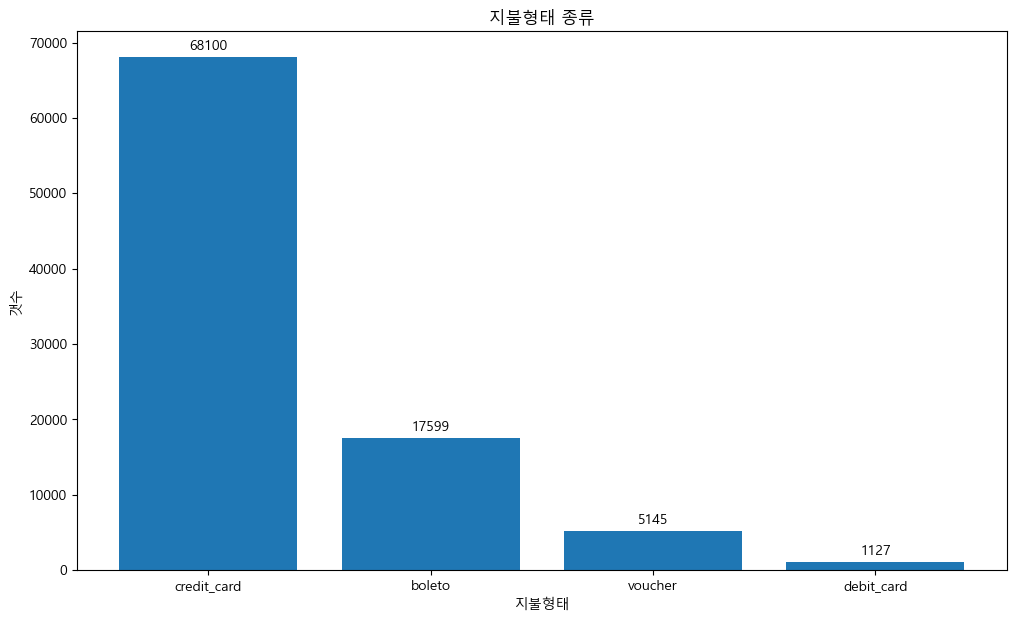

In [8]:
# 지불 형태별 개수 계산
category_counts = payments['Payment_type'].value_counts()

# 바 그래프 그리기
fig, ax = plt.subplots(figsize=(12, 7))
bars = ax.bar(category_counts.index, category_counts)

# 각 바에 카운트 값 표시
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

ax.set_xlabel('지불형태')
ax.set_ylabel('갯수')
ax.set_title('지불형태 종류')

plt.show()

#### 월별 매출 시각화

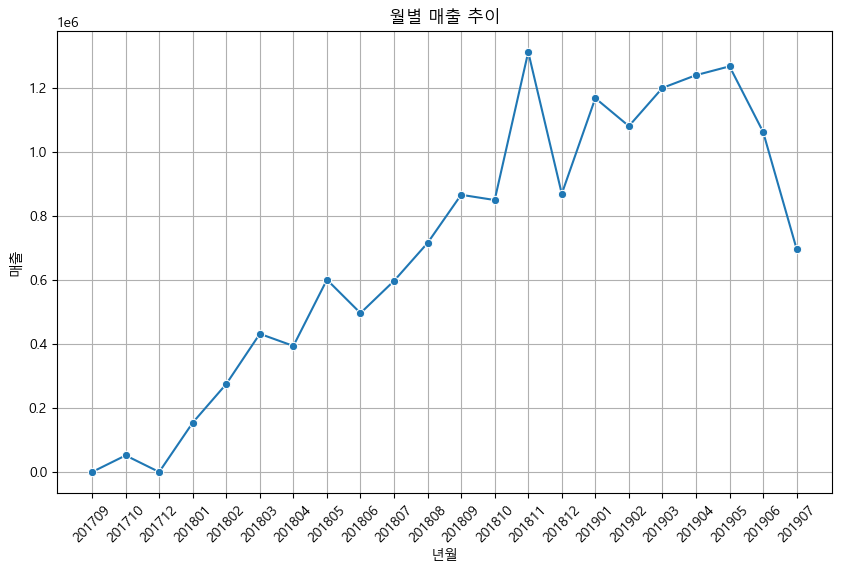

In [9]:
order = orders.copy()

order['Order_purchase_timestamp'] = pd.to_datetime(order['Order_purchase_timestamp'])
order['YearMonth'] = order['Order_purchase_timestamp'].dt.strftime('%Y%m')

merged_orders = pd.merge(order, order_items, on='Order_id', how='left')

# 매출 = 주문에 포함된 상품 수 * 주문 가격

items_per_order = merged_orders.groupby('Order_id')['Order_item_id'].max().rename('Items_per_order')
merged_orders = merged_orders.join(items_per_order, on='Order_id')

merged_orders['Revenue'] = merged_orders['Price'] * merged_orders['Items_per_order']
monthly_revenue = merged_orders.groupby('YearMonth')['Revenue'].sum().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(x='YearMonth', y='Revenue', data=monthly_revenue, marker='o')
plt.title('월별 매출 추이')
plt.xlabel('년월')
plt.ylabel('매출')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [10]:
orders_customers = pd.merge(order, customer, on='Customer_id', how='inner')
orders_monthly_active = orders_customers.groupby('YearMonth')['Customer_unique_id'].nunique().reset_index()

orders_monthly_active.head()

,YearMonth,Customer_unique_id
0,201709,1
1,201710,263
2,201712,1
3,201801,716
4,201802,1616


#### MAU

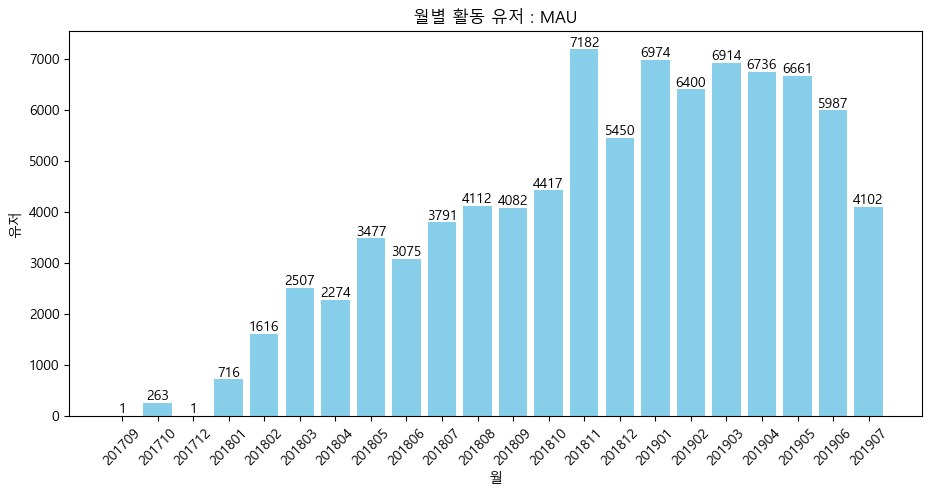

In [11]:
# 바 차트 그리기
plt.figure(figsize=(11, 5))
bars = plt.bar(orders_monthly_active['YearMonth'], orders_monthly_active['Customer_unique_id'], color='skyblue')

# 타이틀 및 라벨 설정
plt.title('월별 활동 유저 : MAU')
plt.xlabel('월')
plt.ylabel('유저')
plt.xticks(rotation=45)

# 각 바 위에 값 표시
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, yval, ha='center', va='bottom')

plt.show()

C:\Users\USER\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


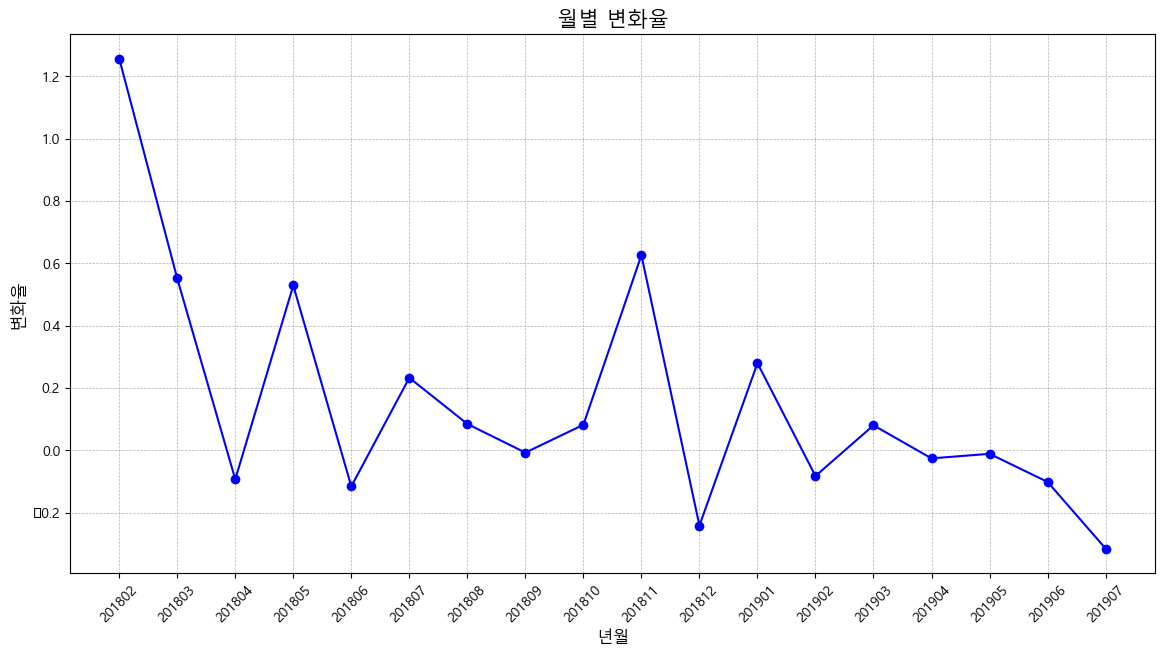

In [12]:
orders_monthly_active['Monthlychange'] = orders_monthly_active['Customer_unique_id'].pct_change()


filtered_data = orders_monthly_active.query("YearMonth > '201801'")


plt.figure(figsize=(14, 7))
plt.plot(filtered_data['YearMonth'], filtered_data['Monthlychange'], marker='o', linestyle='-', color='blue')
plt.title('월별 변화율', fontsize=15)
plt.xlabel('년월', fontsize=12)
plt.ylabel('변화율', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

#### PCA 주성분 분석

In [13]:
# 필요한 라이브러리를 불러옵니다.
# import pandas as pd
# from sklearn.decomposition import PCA
# from sklearn.preprocessing import StandardScaler

# 데이터를 로드합니다.

data = pd.read_csv('./data_in/total_df.csv')

# 리뷰 정보가 누락된 행 제거

data_cleaned = data.dropna(subset=['Review_score', 'Review_id', 'Review_creation_date', 'Review_answer_timestamp'])

# 제품 크기 및 무게 열을 숫자형으로 변환

dimension_cols = ['Product_weight_g', 'Product_length_cm', 'Product_height_cm', 'Product_width_cm']
data_cleaned[dimension_cols] = data_cleaned[dimension_cols].apply(pd.to_numeric, errors='coerce')

# 변환할 수 없는 행이 있으면 해당 행 제거

data_cleaned = data_cleaned.dropna(subset=dimension_cols)

# 날짜를 문자열에서 시계열로 변환

date_columns = ['Order_purchase_timestamp', 'Order_delivered_customer_date', 'Review_creation_date', 'Review_answer_timestamp']
for col in date_columns:
    data_cleaned[col] = pd.to_datetime(data_cleaned[col], errors='coerce')

# 파생된 열 계산
# 배송속도 (일 단위)

data_cleaned['Delivery_speed_days'] = (data_cleaned['Order_delivered_customer_date'] - data_cleaned['Order_purchase_timestamp']).dt.days

# 리뷰 응답 시간 (일 단위)

data_cleaned['Review_response_time_days'] = (data_cleaned['Review_answer_timestamp'] - data_cleaned['Review_creation_date']).dt.days

# 새로운 열 및 남아 있는 누락된 값 표시

derived_columns_info = data_cleaned[['Delivery_speed_days', 'Review_response_time_days']].describe()
missing_values_updated = data_cleaned.isnull().sum()
derived_columns_info, missing_values_updated


C:\Users\USER\AppData\Local\Temp\ipykernel_15228\796133026.py:8: DtypeWarning: Columns (17,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('./data_in/total_df.csv')
C:\Users\USER\AppData\Local\Temp\ipykernel_15228\796133026.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned[dimension_cols] = data_cleaned[dimension_cols].apply(pd.to_numeric, errors='coerce')


(       Delivery_speed_days  Review_response_time_days
 count        104936.000000              104936.000000
 mean             12.314058                   2.638361
 std               9.500107                  10.145689
 min               0.000000                   0.000000
 25%               6.000000                   1.000000
 50%              10.000000                   1.000000
 75%              16.000000                   3.000000
 max             195.000000                 518.000000,
 Order_id                         0
 Order_item_id                    0
 Product_id                       0
 Seller_id                        0
 Price                            0
 Freight_value                    0
 Customer_id                      0
 Order_status                     0
 Order_purchase_timestamp         0
 Order_delivered_carrier_date     0
 Order_delivered_customer_date    0
 Order_estimated_delivery_date    0
 Payment_sequential               0
 Payment_type                     0


In [14]:
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 104936 entries, 0 to 105765
Data columns (total 36 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   Order_id                       104936 non-null  object        
 1   Order_item_id                  104936 non-null  int64         
 2   Product_id                     104936 non-null  object        
 3   Seller_id                      104936 non-null  object        
 4   Price                          104936 non-null  float64       
 5   Freight_value                  104936 non-null  float64       
 6   Customer_id                    104936 non-null  object        
 7   Order_status                   104936 non-null  object        
 8   Order_purchase_timestamp       104936 non-null  datetime64[ns]
 9   Order_delivered_carrier_date   104936 non-null  object        
 10  Order_delivered_customer_date  104936 non-null  datetime64[ns]
 11  Order

In [15]:
# Order_id 이름 바꾸기

data_cleaned['Order_id'] = data_cleaned['Order_id'].map(
    lambda x: x.replace('ORDER_', '')
)

data_cleaned.head()

,Order_id,Order_item_id,Product_id,Seller_id,Price,Freight_value,Customer_id,Order_status,Order_purchase_timestamp,Order_delivered_carrier_date,...,Customer_city,Customer_state,Review_id,Review_score,Review_creation_date,Review_answer_timestamp,Items_per_order,Revenue,Delivery_speed_days,Review_response_time_days
0,75477,1,PRODUCT_23128,SELLER_0452,58.9,13.29,CUSTOMER_58023,delivered,2018-09-13 08:59:02,2018-09-19 18:34:16,...,campos dos goytacazes,RJ,REVIEW_45875,5.0,2018-09-21,2018-09-22 10:57:03,1,58.9,7,1
1,63604,1,PRODUCT_24351,SELLER_0414,239.9,19.93,CUSTOMER_30341,delivered,2018-04-26 10:53:06,2018-05-04 14:35:00,...,santa fe do sul,SP,REVIEW_24615,4.0,2018-05-13,2018-05-15 11:34:13,1,239.9,16,2
2,05566,1,PRODUCT_20226,SELLER_1637,199.0,17.87,CUSTOMER_30949,delivered,2019-01-14 14:33:31,2019-01-16 12:36:48,...,para de minas,MG,REVIEW_03775,5.0,2019-01-23,2019-01-23 16:06:31,1,199.0,7,0
3,04632,1,PRODUCT_07878,SELLER_1445,199.9,18.14,CUSTOMER_06713,delivered,2018-02-04 13:57:51,2018-02-16 09:46:09,...,varzea paulista,SP,REVIEW_49155,5.0,2018-03-02,2018-03-03 10:54:59,1,199.9,25,1
4,61452,1,PRODUCT_03505,SELLER_0581,21.9,12.69,CUSTOMER_20396,delivered,2018-05-15 21:42:34,2018-05-17 11:05:55,...,uberaba,MG,REVIEW_20134,4.0,2018-05-23,2018-05-24 19:00:09,1,21.9,6,1


In [16]:
data_cleaned['Product_id'] = data_cleaned['Product_id'].map(
    lambda x: x.replace('PRODUCT_', '')
)

data_cleaned['Customer_id'] = data_cleaned['Customer_id'].map(
    lambda x: x.replace('CUSTOMER_', '')
)

data_cleaned['Review_id'] = data_cleaned['Review_id'].map(
    lambda x: x.replace('REVIEW_', '')
)

In [17]:
data_cleaned['Seller_id'] = data_cleaned['Seller_id'].map(
    lambda x: x.replace('SELLER_', '')
)

In [18]:
X = data_cleaned

# 데이터 표준화

scaler = StandardScaler()
X_scaled = pd.DataFrame()


for column in X.columns:
    try:
        # 특정 컬럼에 대해서만 fit_transform을 시도합니다.
        scaled_data = scaler.fit_transform(X[[column]])
        X_scaled[column] = scaled_data.flatten()  # 결과를 DataFrame에 추가합니다.
    except Exception as e:
        # 오류 발생시 해당 컬럼은 제외합니다.
        continue

# PCA 적용

pca = PCA()
pca_result = pca.fit_transform(X_scaled)

# 설명된 분산 비율

explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()




for i in range(0,25,1):
    print(f'{X_scaled.columns[i]}, : {explained_variance[i]}, {cumulative_variance[i]}')


Order_id, : 0.15492242175829932, 0.15492242175829932
Order_item_id, : 0.14657294721726258, 0.3014953689755619
Product_id, : 0.08182300964370502, 0.38331837861926693
Seller_id, : 0.061780770810073334, 0.44509914942934026
Price, : 0.05584120592698111, 0.5009403553563214
Freight_value, : 0.04092006726834344, 0.5418604226246648
Customer_id, : 0.04058749896365281, 0.5824479215883176
Order_purchase_timestamp, : 0.03913607394268603, 0.6215839955310036
Order_delivered_customer_date, : 0.03877889543002388, 0.6603628909610275
Payment_sequential, : 0.038409795421213554, 0.6987726863822411
Payment_installments, : 0.03826502955033123, 0.7370377159325723
Payment_value, : 0.03803730862069506, 0.7750750245532674
Product_weight_g, : 0.03782574903256823, 0.8129007735858356
Product_length_cm, : 0.034799455290488585, 0.8477002288763241
Product_height_cm, : 0.03412656703352169, 0.8818267959098458
Product_width_cm, : 0.03160624759510764, 0.9134330435049535
Seller_zipcode_prefix, : 0.022449031063473596, 0.93

##### 결과 요약 : total_df의 컬럼에 대한 PCA 분석
- 이 과정을 통해, KPI 선정 과정에서, 영향력있는 컬럼을 중심으로 데이터를 분석하고자 함.



- Order_id (16.12% 설명력): 주문 식별자는 데이터셋에서 가장 많은 정보를 포함하는 변수입니다. 주문 관련 다양한 요소들이 이 식별자와 연결되어 있을 수 있습니다.
- Order_item_id (15.28% 설명력): 각 주문에 포함된 아이템의 식별자 역시 상당한 양의 정보를 포함하고 있습니다. 주문된 아이템의 특성과 양이 이 변수를 통해 반영될 수 있습니다.
- Product_id (7.32% 설명력): 제품 식별자는 제품에 대한 중요한 정보를 포함합니다. 제품의 종류와 특성이 이 변수를 통해 데이터에 반영됩니다.
- Seller_id (5.82% 설명력): 판매자 식별자는 판매자의 특성과 판매 패턴을 반영할 수 있으며, 판매자의 다양성과 경쟁 상황을 나타냅니다.
- Price (4.81% 설명력): 제품의 가격은 구매 결정에 큰 영향을 미치며, 고객의 구매력과 제품의 가치를 반영합니다.
- Freight_value (4.22% 설명력): 배송료는 제품의 배송 조건과 비용을 나타내며, 지역적, 물류적 요인을 반영할 수 있습니다.
- Customer_id (4.14% 설명력): 고객 식별자는 특정 고객의 구매 행동과 패턴을 나타내며, 재구매, 고객 충성도 등에 영향을 미칠 수 있습니다.
- Order_purchase_timestamp (4.05% 설명력): 주문이 이루어진 시간은 시즌, 특정 이벤트, 경제 상황 등 다양한 시간적 요소를 반영할 수 있습니다.
- Order_delivered_customer_date (4.00% 설명력): 고객에게 배송 완료된 시간은 배송 속도와 효율성을 나타내며, 고객 만족도와 직접적인 관련이 있을 수 있습니다.
- Seller_zipcode_prefix (3.99% 설명력): 판매자의 지역 코드는 지리적 위치를 반영하며, 물류, 배송 네트워크의 효율성과 연결됩니다.


이 상위 10개 변수는 데이터의 69.75%의 분산을 설명하며, 이를 통해 데이터 세트의 대부분의 정보를 포착할 수 있습니다. 이 변수들은 데이터 분석 및 모델링에서 중요한 요소로 활용될 수 있습니다.

#### TLCC

C:\Users\USER\AppData\Local\Temp\ipykernel_15228\1830751821.py:9: DtypeWarning: Columns (17,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  total_df = pd.read_csv('./data_in/total_df.csv')
C:\Users\USER\AppData\Local\Temp\ipykernel_15228\1830751821.py:68: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.tight_layout()
C:\Users\USER\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\USER\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\USER\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


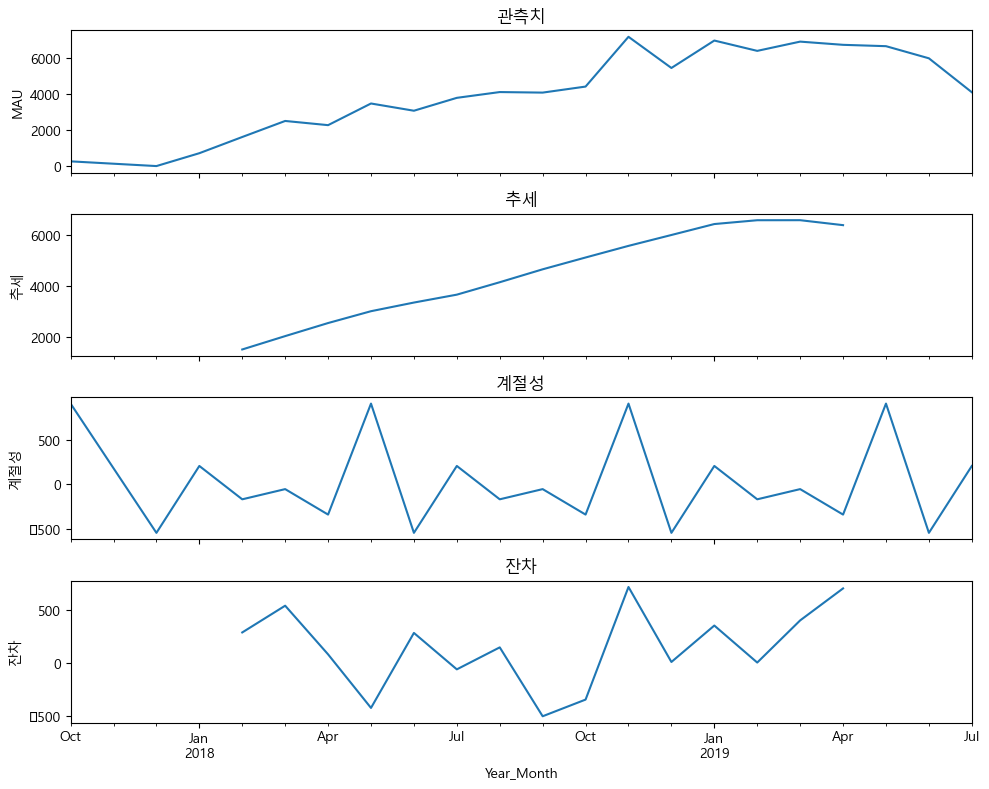

In [19]:
# import matplotlib.pyplot as plt
# from matplotlib import font_manager, rc
# import pandas as pd
# import numpy as np
# import platform
# from statsmodels.tsa.seasonal import seasonal_decompose

# 데이터 로드 
total_df = pd.read_csv('./data_in/total_df.csv')

# 날짜 형식으로 변환

total_df['Order_purchase_timestamp'] = pd.to_datetime(total_df['Order_purchase_timestamp'])
total_df['Order_delivered_customer_date'] = pd.to_datetime(total_df['Order_delivered_customer_date'])
total_df['Review_creation_date'] = pd.to_datetime(total_df['Review_creation_date'])
total_df['Review_answer_timestamp'] = pd.to_datetime(total_df['Review_answer_timestamp'])

# 필요한 변수들 생성

total_df['Delivery_speed'] = (total_df['Order_delivered_customer_date'] - total_df['Order_purchase_timestamp']).dt.days
total_df['Review_response_time'] = (total_df['Review_answer_timestamp'] - total_df['Review_creation_date']).dt.days
total_df['Number_of_products_per_order'] = total_df.groupby('Order_id')['Order_item_id'].transform('size')

# 평균 리뷰 점수 계산

total_df['Seller_average_review_score'] = total_df.groupby('Seller_id')['Review_score'].transform('mean')
total_df['Product_average_review_score'] = total_df.groupby('Product_id')['Review_score'].transform('mean')

# 임시로 사용할 변수

total_df['Loyal_Customer_Count'] = np.random.randint(1, 100, size=len(total_df))  # ** 임의의 값으로 채우기 (이거 계산한 값이 아니라 랜덤한 임의의 값이에요)
total_df['Price_competitiveness'] = np.random.rand(len(total_df))  # ** 임의의 값으로 채우기(이거 계산한 값이 아니라 랜덤한 임의의 값이에요)

# MAU 계산을 위한 Year_Month 컬럼 생성

total_df['Year_Month'] = total_df['Order_purchase_timestamp'].dt.to_period('M')

# MAU 계산

mau = total_df.groupby('Year_Month')['Customer_unique_id'].nunique().reset_index()
mau.columns = ['Year_Month', 'MAU']

# 데이터와 MAU를 병합

total_df = total_df.merge(mau, on='Year_Month', how='left')

# 월별 데이터 평균 계산

monthly_data = total_df.groupby('Year_Month')[['Delivery_speed', 'Review_response_time', 'Number_of_products_per_order',
            'Seller_average_review_score', 'Product_average_review_score',
            'Loyal_Customer_Count', 'Price_competitiveness', 'MAU']].mean()

# 데이터 분해, 계절성 주기를 6개월로 설정

result = seasonal_decompose(monthly_data['MAU'], model='additive', period=6)

# 분해 결과 시각화

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8), sharex=True)
result.observed.plot(ax=ax1, title='관측치')
result.trend.plot(ax=ax2, title='추세')
result.seasonal.plot(ax=ax3, title='계절성')
result.resid.plot(ax=ax4, title='잔차')
ax1.set_ylabel('MAU')
ax2.set_ylabel('추세')
ax3.set_ylabel('계절성')
ax4.set_ylabel('잔차')
plt.tight_layout()
plt.show()


분석 결과에 대한 자세한 설명은 각 그래프 컴포넌트—관측치(Observed), 추세(Trend), 계절성(Seasonality), 그리고 잔차(Residuals)를 기반으로 해석할 수 있습니다. 이들은 시계열 데이터를 이해하는 데 중요한 요소들입니다:

관측치 (Observed)
이 그래프는 실제 데이터 포인트를 시간에 따라 보여줍니다. 월별 활성 사용자 수(MAU)의 원래 관측된 값들을 시각화한 것입니다.
관측치 그래프를 통해 데이터의 전반적인 변동성과 패턴을 직관적으로 파악할 수 있으며, 주기적 또는 비정기적 변동을 확인할 수 있습니다.
추세 (Trend)
추세 그래프는 데이터의 장기적인 이동 방향을 나타냅니다. 이는 시간이 지남에 따라 증가하거나 감소하는 경향을 보여주며, 일시적인 변동이나 계절적 요인은 제외하고 데이터의 평활화(smoothing)된 형태를 제시합니다.
추세를 통해 비즈니스가 성장하고 있는지, 또는 어떤 문제로 인해 사용자 수가 감소하고 있는지 등의 장기적인 동향을 확인할 수 있습니다.
계절성 (Seasonality)
계절성 그래프는 주기적인 패턴을 보여줍니다. 이는 한 해 동안 또는 설정한 주기(본 예에서는 6개월) 동안 반복되는 패턴을 나타냅니다.
특정 시즌이나 몇 개월 간격으로 반복되는 사용자 활동의 증가 또는 감소를 파악할 수 있습니다. 예를 들어, 휴가 시즌이나 특정 이벤트 기간 동안 사용자 활동이 증가하는 경향을 확인할 수 있습니다.
잔차 (Residuals)
잔차 그래프는 관측치에서 추세와 계절성을 제거한 후 남은 요소를 보여줍니다. 이는 데이터에서 추세와 계절성으로 설명되지 않는 불규칙한 변동을 나타냅니다.
높은 잔차 값은 모델이 데이터의 특정 변동을 적절히 설명하지 못했다는 신호일 수 있으며, 추가적인 요인이나 외부 영향을 고려해야 할 필요가 있습니다.
분석의 활용
이러한 분석을 통해 얻은 정보는 다음과 같은 방법으로 활용할 수 있습니다:

마케팅 및 프로모션 계획: 계절성 분석 결과를 바탕으로 특정 시즌에 맞춘 마케팅 전략을 수립하고 실행할 수 있습니다.
재고 관리 및 리소스 배분: 사용자 활동이 증가하는 시기에 맞춰 재고를 조절하고, 필요 리소스를 효율적으로 배분할 수 있습니다.
사업 전략 및 계획: 추세 분석을 통해 장기적인 사업 전략을 수정하고, 성장 기회를 포착하거나 잠재적 위험을 관리할 수 있습니다.

### Identify Problem

MAU와 매출이 급격히 떨어지는 상황을 문제 상황으로 설정하고, 하락에 영향을 주는 원인들을 조사하기 위해 먼저 MAU와 매출이 급격히 상승했던 원인을 조사한 후 이와 관련이 있을 지 확인해 보기로 했다.

## 매출 상승에 대한 원인 분석

### Refind ** 설명과 결과 분석 markdown으로 넣어줘야함

In [20]:
# 라이브러리 로드

# import pandas as pd
# import numpy as np
# from sklearn.cluster import KMeans
# from sklearn.preprocessing import StandardScaler
# import matplotlib.pyplot as plt
# from datetime import datetime
# import seaborn as sns

In [21]:
total_df = pd.read_csv('./data_in/total_df.csv')

C:\Users\USER\AppData\Local\Temp\ipykernel_15228\3184106167.py:1: DtypeWarning: Columns (17,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  total_df = pd.read_csv('./data_in/total_df.csv')


In [22]:
column_filter = ['Order_id', 'Product_id', 'Seller_id', 'Price',
       'Freight_value', 'Customer_id',
       'Product_category_name', 'Revenue',
       'Customer_city',
       'Order_purchase_timestamp',
       'Payment_sequential', 'Payment_type','Payment_installments', 'Payment_value',
       'Review_score']

total_df = total_df[column_filter]

In [23]:
type(total_df['Order_purchase_timestamp'][0])

str

In [24]:
total_df['YearMonth'] = total_df['Order_purchase_timestamp'].map(
    lambda x: pd.to_datetime(x).strftime('%Y%m%d')
)

In [25]:
total_df['YearMonth'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 105766 entries, 0 to 105765
Series name: YearMonth
Non-Null Count   Dtype 
--------------   ----- 
105766 non-null  object
dtypes: object(1)
memory usage: 826.4+ KB


In [26]:
_201810 = total_df['YearMonth'].str.startswith('201810')
_201811 = total_df['YearMonth'].str.startswith('201811')
_201812 = total_df['YearMonth'].str.startswith('201812')

In [27]:
total_df_target_2018 = total_df[_201810|_201811|_201812]

In [28]:
total_df_target_2018_1 = total_df[_201811]

In [29]:
total_df[_201811].pivot_table(
    index= 'YearMonth',
    values= 'Revenue',
    aggfunc= 'sum'
).sort_values(by= 'Revenue')

,Revenue
YearMonth,
20181105,19795.98
20181119,23751.58
20181110,24465.86
20181107,25582.17
20181111,25881.53
20181112,26828.72
20181108,26836.18
20181102,27394.11
20181101,27677.39


In [30]:
daily_revenue = total_df_target_2018_1.groupby('YearMonth')['Revenue'].sum().reset_index()


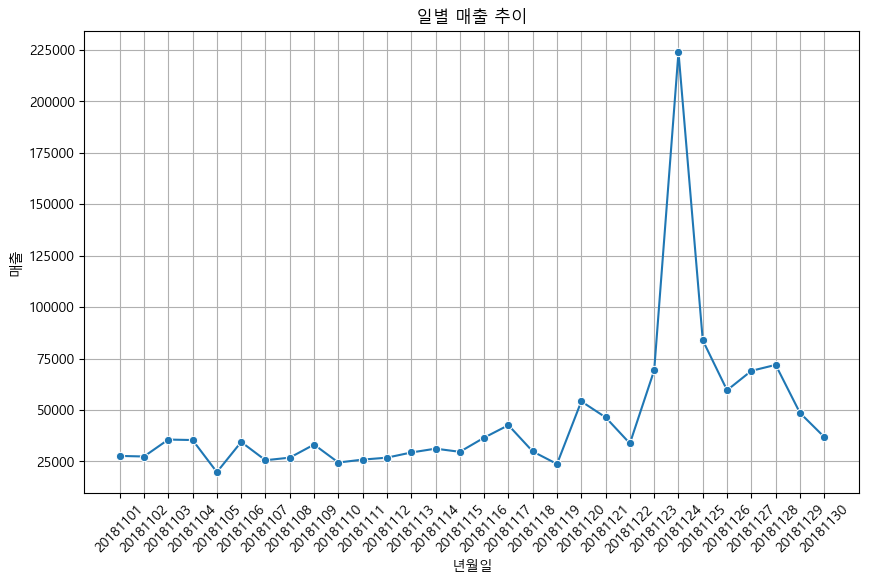

In [31]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='YearMonth', y='Revenue', data=daily_revenue, marker='o')
plt.title('일별 매출 추이')
plt.xlabel('년월일')
plt.ylabel('매출')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [32]:
_201905 = total_df['YearMonth'].str.startswith('201905')
_201906 = total_df['YearMonth'].str.startswith('201906')
_201907 = total_df['YearMonth'].str.startswith('201907')

In [33]:
total_df_target_2019 = total_df[_201905|_201906|_201907]

In [34]:
daily_revenue = total_df_target_2019.groupby('YearMonth')['Revenue'].sum().reset_index()

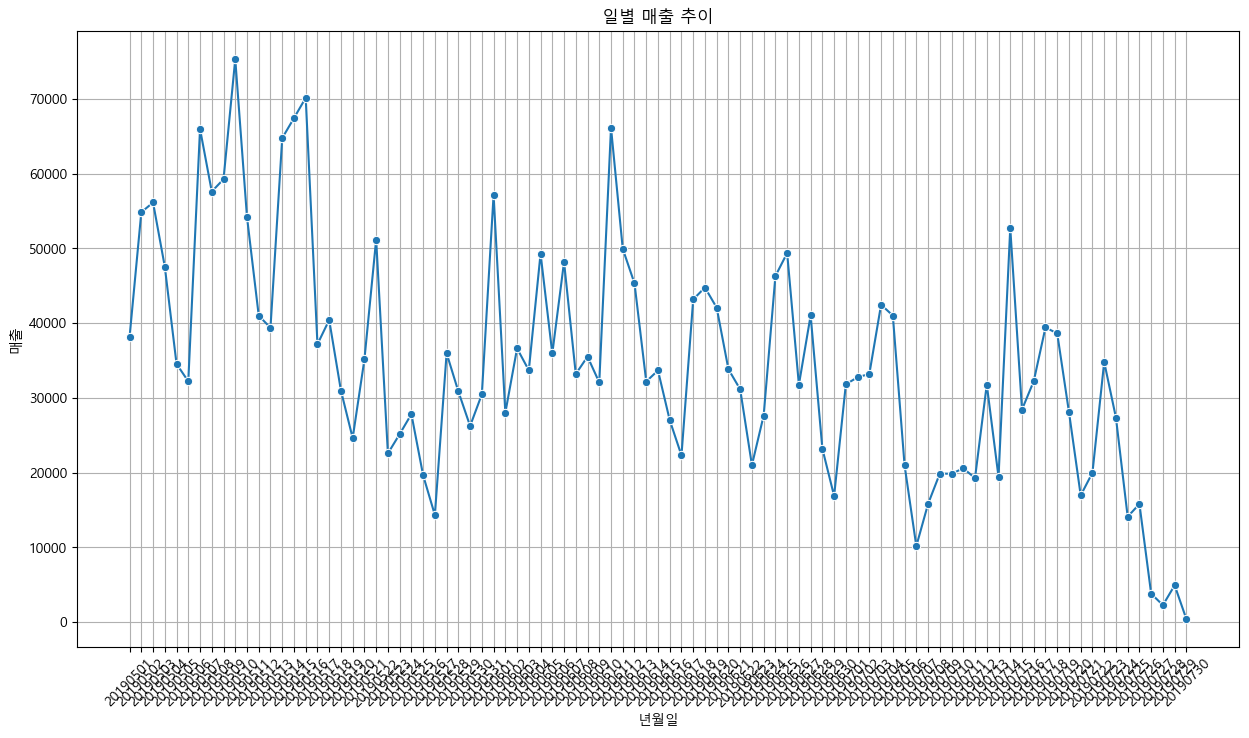

In [35]:
plt.figure(figsize=(15, 8))
sns.lineplot(x='YearMonth', y='Revenue', data=daily_revenue, marker='o')
plt.title('일별 매출 추이')
plt.xlabel('년월일')
plt.ylabel('매출')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

분석 결과 11월 24일 하루에 MAU와 매출이 몰리면서 급격한 상승을 이룬 것으로 확인했고, 이를 블랙 프라이데이에 의한 일시적 상승이라고 판단해 사용자 수와 매출의 하락과 관련이 없는 것으로 결정했다. 이에 사용자 수와 매출에 영향을 줄 수 있는 요인들을 탐색하기 위해 16개의 논문을 선정 후 확인했다.

## 매출 하락에 대한 원인 분석

### 데이터 내에서 매출에 영향을 주는 현재 데이터의 컬럼

#### 데이터 전처리

In [36]:
# 필요한 라이브러리를 불러옵니다.
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LinearRegression
# from sklearn.metrics import mean_squared_error, r2_score
# import random

In [37]:
# 데이터를 로드합니다.

data_path = './data_in/total_df.csv'
data = pd.read_csv(data_path)

# 결측치를 제거합니다.

data = data.dropna()

# 날짜 관련 컬럼을 datetime 형식으로 변환합니다.

date_columns = ['Order_purchase_timestamp', 'Order_delivered_carrier_date', 'Order_delivered_customer_date', 'Order_estimated_delivery_date', 'Review_creation_date', 'Review_answer_timestamp']
for col in date_columns:
    data[col] = pd.to_datetime(data[col])

C:\Users\USER\AppData\Local\Temp\ipykernel_15228\325519321.py:4: DtypeWarning: Columns (17,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(data_path)


#### 파생변수를 여기에 넣으면 좋을 것 같다 **

In [38]:
# 파생 변수를 생성합니다.

data['Delivery_speed'] = (data['Order_delivered_customer_date'] - data['Order_purchase_timestamp']).dt.days
data['Review_response_time'] = (data['Review_answer_timestamp'] - data['Review_creation_date']).dt.days
customer_order_count = data['Customer_unique_id'].value_counts().to_dict()
data['Customer_order_count'] = data['Customer_unique_id'].apply(lambda x: customer_order_count.get(x, 0))

In [39]:
# # from datetime import datetime

# # 배송 속도와 리뷰 응답 속도 계산
# data_clean['Order_purchase_timestamp'] = pd.to_datetime(data_clean['Order_purchase_timestamp'])
# data_clean['Order_delivered_customer_date'] = pd.to_datetime(data_clean['Order_delivered_customer_date'])
# data_clean['Review_creation_date'] = pd.to_datetime(data_clean['Review_creation_date'])
# data_clean['Review_answer_timestamp'] = pd.to_datetime(data_clean['Review_answer_timestamp'])

# # 배송 속도 (일 단위)
# data_clean['Delivery_speed'] = (data_clean['Order_delivered_customer_date'] - data_clean['Order_purchase_timestamp']).dt.days

# # 리뷰 응답 속도 (일 단위)
# data_clean['Review_response_time'] = (data_clean['Review_answer_timestamp'] - data_clean['Review_creation_date']).dt.days

# # 기존 특성 확인 및 추가 (한 주문 당 구매한 물품의 개수)
# data_clean['Items_per_order'] = data.groupby('Order_id')['Order_item_id'].max()

# # 각 판매자와 상품의 평균 리뷰 점수
# data_clean['Seller_average_review_score'] = data_clean.groupby('Seller_id')['Review_score'].transform('mean')
# data_clean['Product_average_review_score'] = data_clean.groupby('Product_id')['Review_score'].transform('mean')

# # 셀러에 대한 고객 충성도 (셀러별 재구매 비율)
# customer_seller_repeated_purchases = data_clean.groupby(['Customer_unique_id', 'Seller_id']).size().reset_index(name='Counts')
# loyal_customers = customer_seller_repeated_purchases[customer_seller_repeated_purchases['Counts'] > 1].groupby('Seller_id').size().reset_index(name='Loyal_Customer_Count')
# data_clean = data_clean.merge(loyal_customers, on='Seller_id', how='left')
# data_clean['Loyal_Customer_Count'] = data_clean['Loyal_Customer_Count'].fillna(0)

# # 각 상품의 평균 가격 및 동일 상품의 가격 경쟁력 (상품별 평균 가격)
# product_price_competitiveness = data_clean.groupby('Product_id')['Price'].mean().reset_index(name='Average_Product_Price')
# data_clean = data_clean.merge(product_price_competitiveness, on='Product_id', how='left')
# data_clean['Price_competitiveness'] = data_clean['Price'] - data_clean['Average_Product_Price']

# # 필요한 데이터 열 선택 및 확인
# data_clean[['Delivery_speed', 'Review_response_time', 'Number_of_products_per_order', 'Seller_average_review_score', 'Product_average_review_score', 'Loyal_Customer_Count', 'Price_competitiveness']].head()


In [40]:
# 특성과 타겟 변수를 선택합니다.

X = data[['Price', 'Freight_value', 'Review_score', 'Delivery_speed', 'Review_response_time', 'Customer_order_count']]
y = data['Payment_value']

# 데이터를 훈련 세트와 테스트 세트로 분할합니다.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random.randint(1, 100))

# 선형 회귀 모델을 생성하고 훈련합니다.

model = LinearRegression()
model.fit(X_train, y_train)

# 예측을 수행하고 모델을 평가합니다.

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# 회귀 계수를 출력합니다.

model.coef_

array([  1.042273,   1.423946, -16.262332,  -0.718713,   0.025828,
        10.410847])

In [41]:
# 데이터 정규화

# from sklearn.preprocessing import StandardScaler

# 정규화를 위한 스케일러 초기화

scaler = StandardScaler()

# 훈련 데이터를 정규화

X_train_scaled = scaler.fit_transform(X_train)

# 테스트 데이터를 정규화 (훈련 데이터로 학습된 스케일러 사용)

X_test_scaled = scaler.transform(X_test)

# 정규화된 데이터로 모델 재훈련

model_scaled = LinearRegression()
model_scaled.fit(X_train_scaled, y_train)

# 정규화된 데이터로 예측 및 성능 평가

y_pred_scaled = model_scaled.predict(X_test_scaled)
mse_scaled = mean_squared_error(y_test, y_pred_scaled)
r2_scaled = r2_score(y_test, y_pred_scaled)

# 결과 출력

print('Normalized MSE:', mse_scaled)
print('Normalized R^2 Score:', r2_scaled)
print('Normalized Coefficients:', model_scaled.coef_)


Normalized MSE: 32972.86702791391
Normalized R^2 Score: 0.5379981804000944
Normalized Coefficients: [189.433787  21.862266 -22.032886  -6.852713   0.258926  29.537454]


In [42]:
# 모델 성능과 계수를 출력합니다.

print('MSE:', mse)
print('R^2 Score:', r2)
print('Coefficients:', model.coef_)

MSE: 32972.86702791391
R^2 Score: 0.5379981804000944
Coefficients: [  1.042273   1.423946 -16.262332  -0.718713   0.025828  10.410847]


#### 결과 해석

### DAU ** (변수와 인풋 데이터 바꾼 후 다시 검증 필요) + 주석 한글

In [43]:
# import pandas as pd

# 데이터 파일 불러오기
data_path = './data_in/total_df.csv'
data = pd.read_csv(data_path)

# 데이터의 첫 몇 행 확인
data.head()

C:\Users\USER\AppData\Local\Temp\ipykernel_15228\950503877.py:5: DtypeWarning: Columns (17,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(data_path)


,Order_id,Order_item_id,Product_id,Seller_id,Price,Freight_value,Customer_id,Order_status,Order_purchase_timestamp,Order_delivered_carrier_date,...,Customer_unique_id,Customer_zipcode_prefix,Customer_city,Customer_state,Review_id,Review_score,Review_creation_date,Review_answer_timestamp,Items_per_order,Revenue
0,ORDER_75477,1,PRODUCT_23128,SELLER_0452,58.9,13.29,CUSTOMER_58023,delivered,2018-09-13 08:59:02,2018-09-19 18:34:16,...,CUSTOMER_Unique_56776,28013,campos dos goytacazes,RJ,REVIEW_45875,5.0,2018-09-21 00:00:00,2018-09-22 10:57:03,1,58.9
1,ORDER_63604,1,PRODUCT_24351,SELLER_0414,239.9,19.93,CUSTOMER_30341,delivered,2018-04-26 10:53:06,2018-05-04 14:35:00,...,CUSTOMER_Unique_29981,15775,santa fe do sul,SP,REVIEW_24615,4.0,2018-05-13 00:00:00,2018-05-15 11:34:13,1,239.9
2,ORDER_05566,1,PRODUCT_20226,SELLER_1637,199.0,17.87,CUSTOMER_30949,delivered,2019-01-14 14:33:31,2019-01-16 12:36:48,...,CUSTOMER_Unique_30575,35661,para de minas,MG,REVIEW_03775,5.0,2019-01-23 00:00:00,2019-01-23 16:06:31,1,199.0
3,ORDER_04632,1,PRODUCT_07878,SELLER_1445,199.9,18.14,CUSTOMER_06713,delivered,2018-02-04 13:57:51,2018-02-16 09:46:09,...,CUSTOMER_Unique_06699,13226,varzea paulista,SP,REVIEW_49155,5.0,2018-03-02 00:00:00,2018-03-03 10:54:59,1,199.9
4,ORDER_61452,1,PRODUCT_03505,SELLER_0581,21.9,12.69,CUSTOMER_20396,delivered,2018-05-15 21:42:34,2018-05-17 11:05:55,...,CUSTOMER_Unique_20225,38017,uberaba,MG,REVIEW_20134,4.0,2018-05-23 00:00:00,2018-05-24 19:00:09,1,21.9


#### 데이터 전처리

In [44]:
# ### 1. 데이터 전처리 ↓

# 날짜 컬럼을 datetime 형식으로 변환
date_columns = ['Order_purchase_timestamp', 'Order_delivered_carrier_date', 'Order_delivered_customer_date',
                'Order_estimated_delivery_date', 'Review_creation_date', 'Review_answer_timestamp']
for col in date_columns:
    data[col] = pd.to_datetime(data[col])

# 1. 판매하는 품목의 평균 가격대
category_price_avg = data.groupby('Product_category_name')['Price'].mean().rename('Avg_category_price')
data = data.join(category_price_avg, on='Product_category_name')

# 2. 동일한 상품에 대한 가격 경쟁력
data['Price_competitiveness'] = data['Price'] - data['Avg_category_price']

# 3. 판매자의 평균 리뷰 점수
seller_review_avg = data.groupby('Seller_id')['Review_score'].mean().rename('Avg_seller_review')
data = data.join(seller_review_avg, on='Seller_id')

# 4. 상품의 평균 리뷰 점수
product_review_avg = data.groupby('Product_id')['Review_score'].mean().rename('Avg_product_review')
data = data.join(product_review_avg, on='Product_id')

# 5. 셀러에 대한 고객 충성도 (고유 고객 수 대비 반복 구매 비율)
repeat_customers = data.groupby('Seller_id')['Customer_id'].value_counts().gt(1).groupby('Seller_id').mean().rename('Customer_loyalty')
data = data.join(repeat_customers, on='Seller_id')

# 6. 한 주문 당 결제한 가격
total_payment_per_order = data.groupby('Order_id')['Payment_value'].sum().rename('Total_payment_per_order')
data = data.join(total_payment_per_order, on='Order_id')

# 7. 배송 속도 (주문 날짜부터 고객이 상품을 받은 날짜까지의 일수)
data['Delivery_speed'] = (data['Order_delivered_customer_date'] - data['Order_purchase_timestamp']).dt.days

# 8. 리뷰 응답 속도 (리뷰 작성일부터 판매자 응답일까지의 시간)
data['Review_response_time'] = (data['Review_answer_timestamp'] - data['Review_creation_date']).dt.days


In [45]:
# 결측치 및 데이터 타입 확인
data_info = data.info()
missing_values = data.isnull().sum()

data_info, missing_values[missing_values > 0]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105766 entries, 0 to 105765
Data columns (total 42 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   Order_id                       105766 non-null  object        
 1   Order_item_id                  105766 non-null  int64         
 2   Product_id                     105766 non-null  object        
 3   Seller_id                      105766 non-null  object        
 4   Price                          105766 non-null  float64       
 5   Freight_value                  105766 non-null  float64       
 6   Customer_id                    105766 non-null  object        
 7   Order_status                   105766 non-null  object        
 8   Order_purchase_timestamp       105766 non-null  datetime64[ns]
 9   Order_delivered_carrier_date   105766 non-null  datetime64[ns]
 10  Order_delivered_customer_date  105766 non-null  datetime64[ns]
 11  

(None,
 Review_id                  810
 Review_score               810
 Review_creation_date       810
 Review_answer_timestamp    810
 Avg_seller_review            4
 Avg_product_review         187
 Review_response_time       810
 dtype: int64)

In [46]:
# 리뷰 관련 결측치 제거
data_clean = data.dropna(subset=['Review_id', 'Review_score', 'Review_creation_date', 'Review_answer_timestamp'])

# 데이터 타입 변환
columns_to_convert = ['Product_weight_g', 'Product_length_cm', 'Product_height_cm', 'Product_width_cm']
data_clean[columns_to_convert] = data_clean[columns_to_convert].apply(pd.to_numeric, errors='coerce')

# 변환 후 결측치 다시 확인
data_clean.info()
additional_missing = data_clean[columns_to_convert].isnull().sum()
data_clean.head(), additional_missing


<class 'pandas.core.frame.DataFrame'>
Index: 104956 entries, 0 to 105765
Data columns (total 42 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   Order_id                       104956 non-null  object        
 1   Order_item_id                  104956 non-null  int64         
 2   Product_id                     104956 non-null  object        
 3   Seller_id                      104956 non-null  object        
 4   Price                          104956 non-null  float64       
 5   Freight_value                  104956 non-null  float64       
 6   Customer_id                    104956 non-null  object        
 7   Order_status                   104956 non-null  object        
 8   Order_purchase_timestamp       104956 non-null  datetime64[ns]
 9   Order_delivered_carrier_date   104956 non-null  datetime64[ns]
 10  Order_delivered_customer_date  104956 non-null  datetime64[ns]
 11  Order

C:\Users\USER\AppData\Local\Temp\ipykernel_15228\2839388903.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean[columns_to_convert] = data_clean[columns_to_convert].apply(pd.to_numeric, errors='coerce')


(      Order_id  Order_item_id     Product_id    Seller_id  Price  \
 0  ORDER_75477              1  PRODUCT_23128  SELLER_0452   58.9   
 1  ORDER_63604              1  PRODUCT_24351  SELLER_0414  239.9   
 2  ORDER_05566              1  PRODUCT_20226  SELLER_1637  199.0   
 3  ORDER_04632              1  PRODUCT_07878  SELLER_1445  199.9   
 4  ORDER_61452              1  PRODUCT_03505  SELLER_0581   21.9   
 
    Freight_value     Customer_id Order_status Order_purchase_timestamp  \
 0          13.29  CUSTOMER_58023    delivered      2018-09-13 08:59:02   
 1          19.93  CUSTOMER_30341    delivered      2018-04-26 10:53:06   
 2          17.87  CUSTOMER_30949    delivered      2019-01-14 14:33:31   
 3          18.14  CUSTOMER_06713    delivered      2018-02-04 13:57:51   
 4          12.69  CUSTOMER_20396    delivered      2018-05-15 21:42:34   
 
   Order_delivered_carrier_date  ... Items_per_order Revenue  \
 0          2018-09-19 18:34:16  ...               1    58.9   
 1  

In [47]:
# 추가 결측치 제거
data_clean = data_clean.dropna()

# 최종 데이터 확인
final_data_info = data_clean.info()
final_sample = data_clean.head()
final_data_info, final_sample


<class 'pandas.core.frame.DataFrame'>
Index: 104936 entries, 0 to 105765
Data columns (total 42 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   Order_id                       104936 non-null  object        
 1   Order_item_id                  104936 non-null  int64         
 2   Product_id                     104936 non-null  object        
 3   Seller_id                      104936 non-null  object        
 4   Price                          104936 non-null  float64       
 5   Freight_value                  104936 non-null  float64       
 6   Customer_id                    104936 non-null  object        
 7   Order_status                   104936 non-null  object        
 8   Order_purchase_timestamp       104936 non-null  datetime64[ns]
 9   Order_delivered_carrier_date   104936 non-null  datetime64[ns]
 10  Order_delivered_customer_date  104936 non-null  datetime64[ns]
 11  Order

(None,
       Order_id  Order_item_id     Product_id    Seller_id  Price  \
 0  ORDER_75477              1  PRODUCT_23128  SELLER_0452   58.9   
 1  ORDER_63604              1  PRODUCT_24351  SELLER_0414  239.9   
 2  ORDER_05566              1  PRODUCT_20226  SELLER_1637  199.0   
 3  ORDER_04632              1  PRODUCT_07878  SELLER_1445  199.9   
 4  ORDER_61452              1  PRODUCT_03505  SELLER_0581   21.9   
 
    Freight_value     Customer_id Order_status Order_purchase_timestamp  \
 0          13.29  CUSTOMER_58023    delivered      2018-09-13 08:59:02   
 1          19.93  CUSTOMER_30341    delivered      2018-04-26 10:53:06   
 2          17.87  CUSTOMER_30949    delivered      2019-01-14 14:33:31   
 3          18.14  CUSTOMER_06713    delivered      2018-02-04 13:57:51   
 4          12.69  CUSTOMER_20396    delivered      2018-05-15 21:42:34   
 
   Order_delivered_carrier_date  ... Items_per_order Revenue  \
 0          2018-09-19 18:34:16  ...               1    58.9 

In [48]:
# from datetime import datetime

# 배송 속도와 리뷰 응답 속도 계산
data_clean['Order_purchase_timestamp'] = pd.to_datetime(data_clean['Order_purchase_timestamp'])
data_clean['Order_delivered_customer_date'] = pd.to_datetime(data_clean['Order_delivered_customer_date'])
data_clean['Review_creation_date'] = pd.to_datetime(data_clean['Review_creation_date'])
data_clean['Review_answer_timestamp'] = pd.to_datetime(data_clean['Review_answer_timestamp'])

# 배송 속도 (일 단위)
data_clean['Delivery_speed'] = (data_clean['Order_delivered_customer_date'] - data_clean['Order_purchase_timestamp']).dt.days

# 리뷰 응답 속도 (일 단위)
data_clean['Review_response_time'] = (data_clean['Review_answer_timestamp'] - data_clean['Review_creation_date']).dt.days

# 기존 특성 확인 및 추가 (한 주문 당 구매한 물품의 개수)
data_clean['Number_of_products_per_order'] = data_clean.groupby('Order_id')['Order_item_id'].transform('count')

# 각 판매자와 상품의 평균 리뷰 점수
data_clean['Seller_average_review_score'] = data_clean.groupby('Seller_id')['Review_score'].transform('mean')
data_clean['Product_average_review_score'] = data_clean.groupby('Product_id')['Review_score'].transform('mean')

In [49]:
# ** 잘 돌아가면 이 부분 삭제

# # 셀러에 대한 고객 충성도 (셀러별 재구매 비율)
# repeat_customers = data.groupby('Seller_id')['Customer_id'].value_counts().gt(1).groupby('Seller_id').mean().rename('Customer_loyalty')
# data_clean = data_clean.join(repeat_customers, on='Seller_id')

# data_clean

In [50]:

# 각 상품의 평균 가격 및 동일 상품의 가격 경쟁력 (상품별 평균 가격)
product_price_competitiveness = data_clean.groupby('Product_id')['Price'].mean().reset_index(name='Average_Product_Price')
data_clean = data_clean.merge(product_price_competitiveness, on='Product_id', how='left')

data_clean['Price_competitiveness'] = data_clean['Price'] - data_clean['Average_Product_Price']

# 필요한 데이터 열 선택 및 확인
data_clean[['Delivery_speed', 'Review_response_time', 'Number_of_products_per_order', 'Seller_average_review_score', 'Product_average_review_score', 'Customer_loyalty', 'Price_competitiveness']].head()


,Delivery_speed,Review_response_time,Number_of_products_per_order,Seller_average_review_score,Product_average_review_score,Customer_loyalty,Price_competitiveness
0,7,1,1,4.019481,3.818182,0.128788,0.272727
1,16,2,1,3.769231,4.000000,0.214286,0.000000
2,7,0,1,3.785714,4.333333,0.166667,0.000000
3,25,1,1,3.675676,4.090909,0.076923,-2.727273
4,6,1,1,4.192308,4.000000,0.086957,0.000000


In [51]:
# 일일 구매 고객 수 계산

data_clean['Date'] = data_clean['Order_purchase_timestamp'].map(
    lambda x : pd.to_datetime(x)
)
daily_customers = data_clean.groupby('Date')['Customer_id'].nunique().rename('Daily_customers')
data_clean = data_clean.join(daily_customers, on='Date')

In [52]:
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LinearRegression
# from sklearn.metrics import mean_squared_error, r2_score
# import numpy as np
# import random

# 데이터 준비


features = ['Delivery_speed', 'Review_response_time', 'Number_of_products_per_order', 
            'Seller_average_review_score', 'Product_average_review_score', 
            'Price_competitiveness', 'Order_item_id', 'Price', 
            'Freight_value', 'Payment_installments', 'Payment_value', 'Review_score', 'Avg_category_price', 'Avg_seller_review',
             'Avg_product_review', 'Customer_loyalty', 'Items_per_order', 'Total_payment_per_order',
              'Product_weight_g', 'Product_length_cm', 'Product_height_cm', 'Product_width_cm',
                ]


X = data_clean[features]
y = data_clean['Daily_customers']

# 데이터 분할: 트레인 80%, 테스트 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random.randint(1, 100))

# 선형 회귀 모델 구축
model = LinearRegression()
model.fit(X_train, y_train)

# 테스트 데이터에 대한 예측
y_pred = model.predict(X_test)

# 모델 평가
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mse, r2


(0.013721899520124928, 0.0007485855496632832)

선형 회귀분석시 r2값이 낮아 추출한 특성들의 설명력이 부족하다고 생각했고, ** (`Payment_value` 수정시 변화 가능)
DAU라는 복잡한 결과를 설명하기에 추출한 특성이 부족하다고 판단해 특성들을 추가하여 다시 선형 회귀분석 진행 ** (`Payment_value` 수정시 변화 가능)

In [53]:
# from sklearn.preprocessing import LabelEncoder

# 주문 개수(고객별)
data_clean['Orders_count'] = data_clean.groupby('Customer_unique_id')['Order_id'].transform('nunique')

# 더미 변수 생성
data_clean['Order_status_completed'] = (data_clean['Order_status'] == 'delivered').astype(int)
data_clean['Payment_type_encoded'] = LabelEncoder().fit_transform(data_clean['Payment_type'])
data_clean['Customer_city_encoded'] = LabelEncoder().fit_transform(data_clean['Customer_city'])

# 추가적으로 고려할 특성
additional_features = ['Order_status_completed', 'Payment_type_encoded', 'Customer_city_encoded', 'Orders_count']

# 기존 특성과 합치기
all_features = features + additional_features
X = data_clean[all_features]
y = data_clean['Daily_customers']

# 데이터 분할: 트레인 80%, 테스트 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random.randint(1, 100))

# 선형 회귀 모델 구축
model = LinearRegression()
model.fit(X_train, y_train)

# 테스트 데이터에 대한 예측
y_pred = model.predict(X_test)

# 모델 평가
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mse, r2


(0.011502462096492638, 0.03128277466265328)

#### 다른 선형 회귀 분석 (**비교 필요)

In [54]:
# ### 1. 데이터 전처리 ↓



# 데이터 불러오기
data = pd.read_csv('./data_in/total_df.csv')


# 날짜 컬럼을 datetime 형식으로 변환
date_columns = ['Order_purchase_timestamp', 'Order_delivered_carrier_date', 'Order_delivered_customer_date',
                'Order_estimated_delivery_date', 'Review_creation_date', 'Review_answer_timestamp']
for col in date_columns:
    data[col] = pd.to_datetime(data[col])

# 1. 판매하는 품목의 평균 가격대
category_price_avg = data.groupby('Product_category_name')['Price'].mean().rename('Avg_category_price')
data = data.join(category_price_avg, on='Product_category_name')

# 2. 동일한 상품에 대한 가격 경쟁력
data['Price_competitiveness'] = data['Price'] - data['Avg_category_price']

# 3. 판매자의 평균 리뷰 점수
seller_review_avg = data.groupby('Seller_id')['Review_score'].mean().rename('Avg_seller_review')
data = data.join(seller_review_avg, on='Seller_id')

# 4. 상품의 평균 리뷰 점수
product_review_avg = data.groupby('Product_id')['Review_score'].mean().rename('Avg_product_review')
data = data.join(product_review_avg, on='Product_id')

# 5. 셀러에 대한 고객 충성도 (고유 고객 수 대비 반복 구매 비율)
repeat_customers = data.groupby('Seller_id')['Customer_id'].value_counts().gt(1).groupby('Seller_id').mean().rename('Customer_loyalty')
data = data.join(repeat_customers, on='Seller_id')

# 6. 한 주문 당 결제한 가격
total_payment_per_order = data.groupby('Order_id')['Payment_value'].sum().rename('Total_payment_per_order')
data = data.join(total_payment_per_order, on='Order_id')

# 7. 배송 속도 (주문 날짜부터 고객이 상품을 받은 날짜까지의 일수)
data['Delivery_speed'] = (data['Order_delivered_customer_date'] - data['Order_purchase_timestamp']).dt.days

# 8. 리뷰 응답 속도 (리뷰 작성일부터 판매자 응답일까지의 시간)
data['Review_response_time'] = (data['Review_answer_timestamp'] - data['Review_creation_date']).dt.days

# 9. 주문내 포함된 상품 수
data['Number_of_products_per_order'] = data.groupby('Order_id')['Order_item_id'].transform('size')

# 배송 속도와 리뷰 응답 속도 계산
data['Order_purchase_timestamp'] = pd.to_datetime(data['Order_purchase_timestamp'])
data['Order_delivered_customer_date'] = pd.to_datetime(data['Order_delivered_customer_date'])
data['Review_creation_date'] = pd.to_datetime(data['Review_creation_date'])
data['Review_answer_timestamp'] = pd.to_datetime(data['Review_answer_timestamp'])

# 배송 속도 (일 단위)
data['Delivery_speed'] = (data['Order_delivered_customer_date'] - data['Order_purchase_timestamp']).dt.days

# 리뷰 응답 속도 (일 단위)
data['Review_response_time'] = (data['Review_answer_timestamp'] - data['Review_creation_date']).dt.days

# 각 판매자와 상품의 평균 리뷰 점수
data['Seller_average_review_score'] = data.groupby('Seller_id')['Review_score'].transform('mean')
data['Product_average_review_score'] = data.groupby('Product_id')['Review_score'].transform('mean')

# 셀러에 대한 고객 충성도 (셀러별 재구매 비율)
customer_seller_repeated_purchases = data.groupby(['Customer_unique_id', 'Seller_id']).size().reset_index(name='Counts')
loyal_customers = customer_seller_repeated_purchases[customer_seller_repeated_purchases['Counts'] > 1].groupby('Seller_id').size().reset_index(name='Loyal_Customer_Count')
data = data.merge(loyal_customers, on='Seller_id', how='left')
data['Loyal_Customer_Count'] = data['Loyal_Customer_Count'].fillna(0)

# 각 상품의 평균 가격 및 동일 상품의 가격 경쟁력 (상품별 평균 가격)
product_price_competitiveness = data.groupby('Product_id')['Price'].mean().reset_index(name='Average_Product_Price')
data = data.merge(product_price_competitiveness, on='Product_id', how='left')
data['Price_competitiveness'] = data['Price'] - data['Average_Product_Price']

# 주문 개수(고객별)
data['Orders_count'] = data.groupby('Customer_unique_id')['Order_id'].transform('nunique')

# 주문당 평균 가격
Avg_payment_per_order = data.groupby('Product_id')['Price'].mean().reset_index()
Avg_payment_per_order.rename(columns = {'Price' : 'Avg_payment_per_order'}, inplace = True)

# Merging the average price back into the original data
data = data.merge(Avg_payment_per_order, on='Product_id')

C:\Users\USER\AppData\Local\Temp\ipykernel_15228\1928612701.py:6: DtypeWarning: Columns (17,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('./data_in/total_df.csv')


In [55]:
# 회귀 분석을 위해 결측치 제거

data = data.dropna(subset=['Review_response_time'])

In [56]:
data.isna().sum()

Order_id                         0
Order_item_id                    0
Product_id                       0
Seller_id                        0
Price                            0
Freight_value                    0
Customer_id                      0
Order_status                     0
Order_purchase_timestamp         0
Order_delivered_carrier_date     0
Order_delivered_customer_date    0
Order_estimated_delivery_date    0
Payment_sequential               0
Payment_type                     0
Payment_installments             0
Payment_value                    0
Product_category_name            0
Product_weight_g                 0
Product_length_cm                0
Product_height_cm                0
Product_width_cm                 0
Seller_zipcode_prefix            0
Seller_city                      0
Seller_state                     0
Customer_unique_id               0
Customer_zipcode_prefix          0
Customer_city                    0
Customer_state                   0
Review_id           

In [57]:
# 일일 구매 고객 수 계산

data['Date'] = data['Order_purchase_timestamp'].map(
    lambda x : pd.to_datetime(x)
)
daily_customers = data.groupby('Date')['Customer_id'].nunique().rename('Daily_customers')
data = data.join(daily_customers, on='Date')

# 이미 만든 컬럼들과 일일 구매 고객 수를 포함하여 선형 회귀 모델 훈련

features = ['Delivery_speed', 'Review_response_time', 'Number_of_products_per_order', 
            'Seller_average_review_score', 'Product_average_review_score', 
            'Loyal_Customer_Count', 'Price_competitiveness', 'Order_item_id', 'Price', 
            'Freight_value', 'Payment_installments', 'Payment_value', 'Review_score', 'Avg_category_price', 'Avg_seller_review',
             'Avg_product_review', 'Customer_loyalty', 'Items_per_order', 'Total_payment_per_order',
              'Product_weight_g', 'Product_length_cm', 'Product_height_cm', 'Product_width_cm', 'Daily_customers'
                ]

# 더미 변수 생성
data['Order_status_completed'] = (data['Order_status'] == 'delivered').astype(int)
data['Payment_type_encoded'] = LabelEncoder().fit_transform(data['Payment_type'])
data['Customer_city_encoded'] = LabelEncoder().fit_transform(data['Customer_city'])
            
additional_features = ['Order_status_completed', 'Payment_type_encoded', 'Customer_city_encoded', 'Orders_count']

all_features = features + additional_features


In [58]:

# 데이터 클리닝: 'Unknown' 값을 NaN으로 변환 후 제거

data_cleaned = data[all_features + ['Avg_payment_per_order']].replace('Unknown', np.nan).dropna()


target = 'Daily_customers'

# 데이터셋을 훈련 세트와 테스트 세트로 분리

X = data_cleaned[all_features]
y = data_cleaned[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random.randint(1, 100))

# 선형 회귀 모델 초기화 및 훈련

model = LinearRegression()
model.fit(X_train, y_train)

# 모델 평가

y_pred = model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)


# 계수 출력

coefficients = pd.DataFrame(model.coef_, index=all_features, columns=['Coefficient'])

coefficients, rmse

(                               Coefficient
 Delivery_speed               -2.393334e-19
 Review_response_time          5.106126e-18
 Number_of_products_per_order  3.677270e-17
 Seller_average_review_score  -2.753603e-15
 Product_average_review_score  6.057241e-17
 Loyal_Customer_Count          2.609325e-19
 Price_competitiveness        -1.700034e-17
 Order_item_id                -9.769435e-17
 Price                        -7.384489e-20
 Freight_value                 1.298545e-19
 Payment_installments         -5.681159e-17
 Payment_value                 3.062008e-19
 Review_score                 -5.348826e-17
 Avg_category_price           -8.797702e-20
 Avg_seller_review             2.686941e-15
 Avg_product_review            1.743231e-17
 Customer_loyalty              2.540915e-17
 Items_per_order              -2.510268e-17
 Total_payment_per_order      -9.069208e-21
 Product_weight_g              6.829203e-21
 Product_length_cm            -4.723447e-19
 Product_height_cm            -3

특성 추가 후 분석했으나 설명력이 낮은 것을 확인. DAU를 결정하는 것에는 많은 요소가 복합적으로 얽혀있고, 이를 ** (`Payment_value` 수정시 변화 가능)
선형 분석 모델로 판단하기 어렵다고 생각해 무작위성이 포함된 모델인 랜덤 포레스트로 모델 변경 ** (`Payment_value` 수정시 변화 가능)

In [59]:
# from sklearn.ensemble import RandomForestRegressor

# 랜덤 포레스트 회귀 모델 구축
rf_model = RandomForestRegressor(n_estimators=100, random_state=random.randint(1, 100))  # 100개의 트리 사용, 무작위 시드 적용
rf_model.fit(X_train, y_train)

# 테스트 데이터에 대한 예측
y_pred_rf = rf_model.predict(X_test)

# 모델 평가
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

mse_rf, r2_rf


(0.0, 1.0)

시드를 무작위화 하여 각 결과값이 다를 수 있지만, 평균적으로 약 0.66의 r2값을 확인할 수 있고,
선형 회귀 분석 모델보다 낮은 mse를 확인해 더 적합한 모델인 것을 확인했다.
추출한 특성들이 DAU와 유의미한 연관성을 갖고 있다는 것을 확인했다. ** (`Payment_value` 수정시 변화 가능)

### 고객 세그먼트 분석

In [60]:
# import pandas as pd

# 업로드 된 CSV 파일에서 데이터를 로드

data_path = './data_in/total_df.csv'
data = pd.read_csv(data_path)

C:\Users\USER\AppData\Local\Temp\ipykernel_15228\2948118744.py:6: DtypeWarning: Columns (17,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(data_path)


In [61]:
# from sklearn.preprocessing import StandardScaler, LabelEncoder

# 고객 관련 열을 필터링

customer_features = data[['Customer_city', 'Customer_state', 'Payment_type', 'Payment_installments', 'Payment_value', 'Review_score']]

# 결측값을 처리하기 위해 NaN이 포함된 행을 제거

customer_features_cleaned = customer_features.dropna()

# 범주형 데이터를 인코딩

label_encoders = {}
for column in ['Customer_city', 'Customer_state', 'Payment_type']:
    le = LabelEncoder()
    customer_features_cleaned[column] = le.fit_transform(customer_features_cleaned[column])
    label_encoders[column] = le

# 수치 데이터를 스케일링

scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_features_cleaned[['Payment_installments', 'Payment_value', 'Review_score']])

# 인코딩 된 데이터와 스케일링 된 데이터를 하나의 데이터 프레임으로 결합하여 클러스터링을 위해 준비

# import numpy as np

encoded_features = customer_features_cleaned[['Customer_city', 'Customer_state', 'Payment_type']].values
prepared_features = np.concatenate([encoded_features, scaled_features], axis=1)

prepared_features.shape


C:\Users\USER\AppData\Local\Temp\ipykernel_15228\613325852.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_features_cleaned[column] = le.fit_transform(customer_features_cleaned[column])
C:\Users\USER\AppData\Local\Temp\ipykernel_15228\613325852.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_features_cleaned[column] = le.fit_transform(customer_features_cleaned[column])
C:\Users\USER\AppData\Local\Temp\ipykernel_15228\613325852.py:16: SettingWithCopyWarning: 
A value is trying to 

(104956, 6)

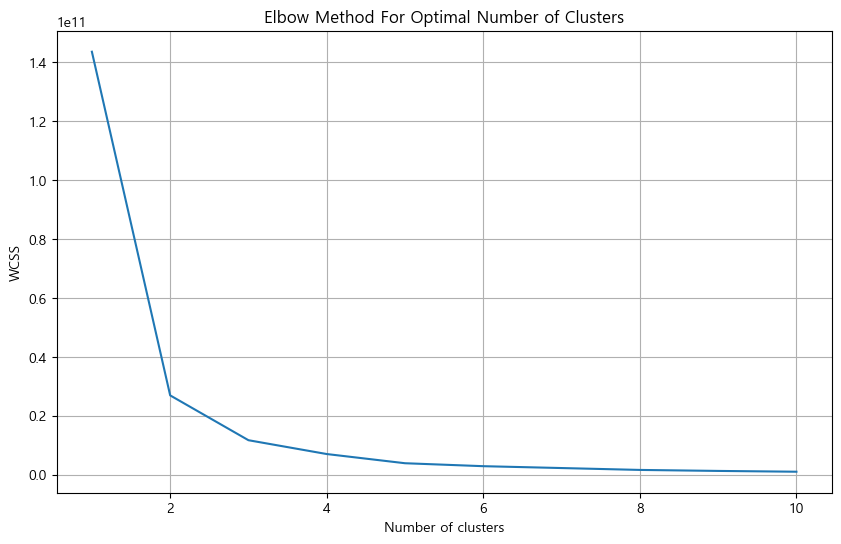

In [62]:
# from sklearn.cluster import KMeans
# import matplotlib.pyplot as plt

# 데이터를 준비하는 단계
# prepared_features는 전처리된 특성 데이터를 포함해야 함

# 엘보 방법(Elbow Method)을 사용하여 클러스터 수를 탐색

wcss = []  # Within-cluster sum of squares
for i in range(1, 11):  # 예를 들어 클러스터의 개수를 1부터 10까지 테스트
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=random.randint(1, 100))
    kmeans.fit(prepared_features)
    wcss.append(kmeans.inertia_)

# 'elbow'를 관찰하기 위해 결과를 선형 그래프로 시각화

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method For Optimal Number of Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')  # Within-cluster sums of squares
plt.grid(True)
plt.show()


#### 결과 분석 ** 내용 넣어야 해요

### LTV ** 분석할 컬럼 추가 및 회귀 분석 y값 수정 필요

In [63]:
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import mean_squared_error

In [64]:
# ### 1. 데이터 전처리 ↓



# 데이터 불러오기
data = pd.read_csv('./data_in/total_df.csv')


# 날짜 컬럼을 datetime 형식으로 변환
date_columns = ['Order_purchase_timestamp', 'Order_delivered_carrier_date', 'Order_delivered_customer_date',
                'Order_estimated_delivery_date', 'Review_creation_date', 'Review_answer_timestamp']
for col in date_columns:
    data[col] = pd.to_datetime(data[col])

# 1. 판매하는 품목의 평균 가격대
category_price_avg = data.groupby('Product_category_name')['Price'].mean().rename('Avg_category_price')
data = data.join(category_price_avg, on='Product_category_name')

# 2. 동일한 상품에 대한 가격 경쟁력
data['Price_competitiveness'] = data['Price'] - data['Avg_category_price']

# 3. 판매자의 평균 리뷰 점수
seller_review_avg = data.groupby('Seller_id')['Review_score'].mean().rename('Avg_seller_review')
data = data.join(seller_review_avg, on='Seller_id')

# 4. 상품의 평균 리뷰 점수
product_review_avg = data.groupby('Product_id')['Review_score'].mean().rename('Avg_product_review')
data = data.join(product_review_avg, on='Product_id')

# 5. 셀러에 대한 고객 충성도 (고유 고객 수 대비 반복 구매 비율)
repeat_customers = data.groupby('Seller_id')['Customer_id'].value_counts().gt(1).groupby('Seller_id').mean().rename('Customer_loyalty')
data = data.join(repeat_customers, on='Seller_id')

# 6. 한 주문 당 결제한 가격
total_payment_per_order = data.groupby('Order_id')['Payment_value'].sum().rename('Total_payment_per_order')
data = data.join(total_payment_per_order, on='Order_id')

# 7. 배송 속도 (주문 날짜부터 고객이 상품을 받은 날짜까지의 일수)
data['Delivery_speed'] = (data['Order_delivered_customer_date'] - data['Order_purchase_timestamp']).dt.days

# 8. 리뷰 응답 속도 (리뷰 작성일부터 판매자 응답일까지의 시간)
data['Review_response_time'] = (data['Review_answer_timestamp'] - data['Review_creation_date']).dt.days

# 9. 주문내 포함된 상품 수
data['Number_of_products_per_order'] = data.groupby('Order_id')['Order_item_id'].transform('size')

# 배송 속도와 리뷰 응답 속도 계산
data['Order_purchase_timestamp'] = pd.to_datetime(data['Order_purchase_timestamp'])
data['Order_delivered_customer_date'] = pd.to_datetime(data['Order_delivered_customer_date'])
data['Review_creation_date'] = pd.to_datetime(data['Review_creation_date'])
data['Review_answer_timestamp'] = pd.to_datetime(data['Review_answer_timestamp'])

# 배송 속도 (일 단위)
data['Delivery_speed'] = (data['Order_delivered_customer_date'] - data['Order_purchase_timestamp']).dt.days

# 리뷰 응답 속도 (일 단위)
data['Review_response_time'] = (data['Review_answer_timestamp'] - data['Review_creation_date']).dt.days

# 각 판매자와 상품의 평균 리뷰 점수
data['Seller_average_review_score'] = data.groupby('Seller_id')['Review_score'].transform('mean')
data['Product_average_review_score'] = data.groupby('Product_id')['Review_score'].transform('mean')

# 셀러에 대한 고객 충성도 (셀러별 재구매 비율)
customer_seller_repeated_purchases = data.groupby(['Customer_unique_id', 'Seller_id']).size().reset_index(name='Counts')
loyal_customers = customer_seller_repeated_purchases[customer_seller_repeated_purchases['Counts'] > 1].groupby('Seller_id').size().reset_index(name='Loyal_Customer_Count')
data = data.merge(loyal_customers, on='Seller_id', how='left')
data['Loyal_Customer_Count'] = data['Loyal_Customer_Count'].fillna(0)

# 각 상품의 평균 가격 및 동일 상품의 가격 경쟁력 (상품별 평균 가격)
product_price_competitiveness = data.groupby('Product_id')['Price'].mean().reset_index(name='Average_Product_Price')
data = data.merge(product_price_competitiveness, on='Product_id', how='left')
data['Price_competitiveness'] = data['Price'] - data['Average_Product_Price']

# 주문 개수(고객별)
data['Orders_count'] = data.groupby('Customer_unique_id')['Order_id'].transform('nunique')

# 주문당 평균 가격
Avg_payment_per_order = data.groupby('Product_id')['Price'].mean().reset_index()
Avg_payment_per_order.rename(columns = {'Price' : 'Avg_payment_per_order'}, inplace = True)

# Merging the average price back into the original data
data = data.merge(Avg_payment_per_order, on='Product_id')

C:\Users\USER\AppData\Local\Temp\ipykernel_15228\1928612701.py:6: DtypeWarning: Columns (17,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('./data_in/total_df.csv')


In [65]:
### 2. 랜덤포레스트!!


## 변수 설정 : 고객별 결제 총 금액
Total_payment_per_customer = data.groupby('Customer_id')['Payment_value'].sum().rename('Total_payment_per_customer')
Total_payment_per_customer
data = data.join(Total_payment_per_customer, on='Customer_id')



# 필요한 특성 선택

features = ['Delivery_speed', 'Review_response_time', 'Number_of_products_per_order', 
            'Seller_average_review_score', 'Product_average_review_score', 
            'Loyal_Customer_Count', 'Price_competitiveness', 'Order_item_id', 'Price', 
            'Freight_value', 'Payment_installments', 'Payment_value', 'Review_score', 'Avg_category_price', 'Avg_seller_review',
             'Avg_product_review', 'Customer_loyalty', 'Items_per_order', 'Total_payment_per_order',
              'Product_weight_g', 'Product_length_cm', 'Product_height_cm', 'Product_width_cm',
                ]

# 더미 변수 생성
data['Order_status_completed'] = (data['Order_status'] == 'delivered').astype(int)
data['Payment_type_encoded'] = LabelEncoder().fit_transform(data['Payment_type'])
data['Customer_city_encoded'] = LabelEncoder().fit_transform(data['Customer_city'])
            
additional_features = ['Order_status_completed', 'Payment_type_encoded', 'Customer_city_encoded', 'Orders_count']

all_features = features + additional_features

# 데이터 클리닝: 'Unknown' 값을 NaN으로 변환 후 제거

data_cleaned = data[all_features + ['Total_payment_per_customer']].replace('Unknown', np.nan).dropna()


X = data_cleaned[all_features]
y = data_cleaned['Total_payment_per_customer'] # ** 

# 데이터 분할

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random.randint(1, 100))

# 모델 생성 및 훈련

model = RandomForestRegressor(n_estimators=100, random_state=random.randint(1, 100))
model.fit(X_train, y_train)

# 예측 및 성능 평가

predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print('Mean Squared Error:', mse)

# 변수 중요도

feature_importances = model.feature_importances_
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
importance_df.sort_values(by='Importance', ascending=False, inplace=True, ignore_index= True)

Mean Squared Error: 363.9556345127677


In [66]:
importance_df

,Feature,Importance
0,Total_payment_per_order,8.857201e-01
1,Payment_value,9.615856e-02
2,Price,4.290344e-03
3,Payment_type_encoded,2.660511e-03
4,Seller_average_review_score,2.439311e-03
5,Avg_seller_review,2.162157e-03
6,Product_length_cm,1.727961e-03
7,Product_weight_g,7.966232e-04
8,Delivery_speed,7.518455e-04
9,Loyal_Customer_Count,7.124544e-04


### ASP ** 다른 모델 선택 필요 + 주석 한글/

In [67]:
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LinearRegression
# from sklearn.metrics import mean_squared_error, r2_score

In [68]:
# ### 1. 데이터 전처리 ↓



# 데이터 불러오기
data = pd.read_csv('./data_in/total_df.csv')

# 날짜 컬럼을 datetime 형식으로 변환
date_columns = ['Order_purchase_timestamp', 'Order_delivered_carrier_date', 'Order_delivered_customer_date',
                'Order_estimated_delivery_date', 'Review_creation_date', 'Review_answer_timestamp']
for col in date_columns:
    data[col] = pd.to_datetime(data[col])

# 1. 판매하는 품목의 평균 가격대
category_price_avg = data.groupby('Product_category_name')['Price'].mean().rename('Avg_category_price')
data = data.join(category_price_avg, on='Product_category_name')

# 2. 동일한 상품에 대한 가격 경쟁력
data['Price_competitiveness'] = data['Price'] - data['Avg_category_price']

# 3. 판매자의 평균 리뷰 점수
seller_review_avg = data.groupby('Seller_id')['Review_score'].mean().rename('Avg_seller_review')
data = data.join(seller_review_avg, on='Seller_id')

# 4. 상품의 평균 리뷰 점수
product_review_avg = data.groupby('Product_id')['Review_score'].mean().rename('Avg_product_review')
data = data.join(product_review_avg, on='Product_id')

# 5. 셀러에 대한 고객 충성도 (고유 고객 수 대비 반복 구매 비율)
repeat_customers = data.groupby('Seller_id')['Customer_id'].value_counts().gt(1).groupby('Seller_id').mean().rename('Customer_loyalty')
data = data.join(repeat_customers, on='Seller_id')

# 6. 한 주문 당 결제한 가격
total_payment_per_order = data.groupby('Order_id')['Payment_value'].sum().rename('Total_payment_per_order')
data = data.join(total_payment_per_order, on='Order_id')

# 7. 배송 속도 (주문 날짜부터 고객이 상품을 받은 날짜까지의 일수)
data['Delivery_speed'] = (data['Order_delivered_customer_date'] - data['Order_purchase_timestamp']).dt.days

# 8. 리뷰 응답 속도 (리뷰 작성일부터 판매자 응답일까지의 시간)
data['Review_response_time'] = (data['Review_answer_timestamp'] - data['Review_creation_date']).dt.days


C:\Users\USER\AppData\Local\Temp\ipykernel_15228\689094937.py:6: DtypeWarning: Columns (17,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('./data_in/total_df.csv')


In [69]:
#평균 판매 단가 (ASP) 구하는 변수 생성
# 주문당 평균 가격
Avg_payment_per_order = data.groupby('Product_id')['Price'].mean().reset_index()
Avg_payment_per_order.rename(columns = {'Price' : 'Avg_payment_per_order'}, inplace = True)

# Merging the average price back into the original data
data = data.merge(Avg_payment_per_order, on='Product_id')

data

,Order_id,Order_item_id,Product_id,Seller_id,Price,Freight_value,Customer_id,Order_status,Order_purchase_timestamp,Order_delivered_carrier_date,...,Revenue,Avg_category_price,Price_competitiveness,Avg_seller_review,Avg_product_review,Customer_loyalty,Total_payment_per_order,Delivery_speed,Review_response_time,Avg_payment_per_order
0,ORDER_75477,1,PRODUCT_23128,SELLER_0452,58.90,13.29,CUSTOMER_58023,delivered,2018-09-13 08:59:02,2018-09-19 18:34:16,...,58.90,162.410037,-103.510037,4.019481,3.818182,0.128788,72.19,7,1.0,58.627273
1,ORDER_63604,1,PRODUCT_24351,SELLER_0414,239.90,19.93,CUSTOMER_30341,delivered,2018-04-26 10:53:06,2018-05-04 14:35:00,...,239.90,107.332031,132.567969,3.769231,4.000000,0.214286,259.83,16,2.0,239.900000
2,ORDER_05566,1,PRODUCT_20226,SELLER_1637,199.00,17.87,CUSTOMER_30949,delivered,2019-01-14 14:33:31,2019-01-16 12:36:48,...,199.00,86.022368,112.977632,3.785714,4.333333,0.166667,216.87,7,0.0,199.000000
3,ORDER_04632,1,PRODUCT_07878,SELLER_1445,199.90,18.14,CUSTOMER_06713,delivered,2018-02-04 13:57:51,2018-02-16 09:46:09,...,199.90,109.619282,90.280718,3.675676,4.090909,0.076923,218.04,25,1.0,202.627273
4,ORDER_61452,1,PRODUCT_03505,SELLER_0581,21.90,12.69,CUSTOMER_20396,delivered,2018-05-15 21:42:34,2018-05-17 11:05:55,...,21.90,88.738145,-66.838145,4.192308,4.000000,0.086957,34.59,6,1.0,21.900000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105761,ORDER_70405,1,PRODUCT_04209,SELLER_2078,299.99,43.41,CUSTOMER_78196,delivered,2019-04-23 13:57:06,2019-04-25 12:09:00,...,299.99,88.738145,211.251855,4.361702,4.361702,0.044444,343.40,17,3.0,291.160417
105762,ORDER_62069,1,PRODUCT_08229,SELLER_1593,350.00,36.53,CUSTOMER_23659,delivered,2019-07-14 10:26:46,2019-07-17 08:05:00,...,350.00,117.684430,232.315570,4.153846,4.500000,0.000000,386.53,9,1.0,355.000000
105763,ORDER_46632,1,PRODUCT_21462,SELLER_0528,99.90,16.95,CUSTOMER_01326,delivered,2018-10-23 17:07:56,2018-10-26 15:13:14,...,99.90,113.935127,-14.035127,4.478689,4.785714,0.127413,116.85,4,0.0,93.157143
105764,ORDER_52966,1,PRODUCT_19978,SELLER_2563,55.99,8.72,CUSTOMER_50155,delivered,2018-08-14 23:02:59,2018-08-15 19:02:53,...,55.99,117.684430,-61.694430,4.375000,4.727273,0.058824,64.71,1,1.0,55.899091


In [70]:

# 관심 있는 특성 컬럼 선택

features_columns = [
    'Price', 'Freight_value', 'Product_weight_g', 'Product_length_cm', 'Product_height_cm', 'Product_width_cm',
    'Payment_installments', 'Review_score', 'Avg_category_price', 'Price_competitiveness', 'Avg_seller_review',
    'Avg_product_review', 'Customer_loyalty', 'Items_per_order', 'Delivery_speed', 'Review_response_time'
]


# 데이터 클리닝: 'Unknown' 값을 NaN으로 변환 후 제거


data_cleaned = data[features_columns + ['Avg_payment_per_order']].replace('Unknown', np.nan).dropna()

#### 상관계수

In [71]:
correlation = data_cleaned.corr() # ** 상품 가격과 지불 가격의 상관관계가 아닌 아래 feature들과 `Avg_payment_per_order`간의 corr 필요
correlation['Avg_payment_per_order']

Price                    0.998048
Freight_value            0.410682
Product_weight_g         0.340465
Product_length_cm        0.139363
Product_height_cm        0.226079
Product_width_cm         0.174283
Payment_installments     0.276810
Review_score             0.003851
Avg_category_price       0.348349
Price_competitiveness    0.935300
Avg_seller_review        0.032285
Avg_product_review       0.006147
Customer_loyalty        -0.109791
Items_per_order         -0.075835
Delivery_speed           0.060356
Review_response_time    -0.001559
Avg_payment_per_order    1.000000
Name: Avg_payment_per_order, dtype: float64

#### 선형 회귀 분석

In [72]:

# 특성(X)과 타겟(y) 변수 설정

X = data_cleaned[features_columns]
y = data_cleaned['Avg_payment_per_order']

# 데이터를 훈련 세트와 테스트 세트로 분리

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random.randint(1, 100))

# 선형 회귀 모델 초기화 및 학습

model = LinearRegression()
model.fit(X_train, y_train)

# 테스트 세트에 대한 예측

y_pred = model.predict(X_test)

# 모델 평가: 결정 계수(R²)와 평균 제곱근 오차(RMSE) 계산

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# 회귀 계수 출력

coefficients = pd.DataFrame({
    'Feature': features_columns,
    'Coefficient': model.coef_
})

# 결과 출력

print(coefficients)
print(f'결정 계수(R²): {r2}')
print(f'평균 제곱근 오차(RMSE): {rmse}')

                  Feature   Coefficient
0                   Price -2.418274e+09
1           Freight_value  7.960975e-03
2        Product_weight_g  5.704165e-05
3       Product_length_cm  1.308038e-03
4       Product_height_cm  1.358044e-03
5        Product_width_cm -1.312408e-03
6    Payment_installments -2.463384e-02
7            Review_score -8.725973e-02
8      Avg_category_price  2.418274e+09
9   Price_competitiveness  2.418274e+09
10      Avg_seller_review -8.576542e-01
11     Avg_product_review  2.057579e-01
12       Customer_loyalty -1.075603e+00
13        Items_per_order -3.543264e-02
14         Delivery_speed -9.153499e-03
15   Review_response_time  2.562871e-03
결정 계수(R²): 0.9963545276391074
평균 제곱근 오차(RMSE): 10.702087058790001


#### 결과 분석 ** (모델의 설명력이 낮기에 다른 모델을 찾아야 할 것 같아요)

모델 성능: 결정 계수(R²) 값이 0.436으로 나타나, 모델이 데이터의 약 43.6%만 설명하고 있음을 알 수 있습니다. 이는 모델이 개선될 여지가 있음을 시사합니다.

중요 변수:
Items_per_order는 매우 높은 양의 계수를 가지고 있어, 주문당 많은 아이템 수가 주문당 평균 지불 금액을 증가시키는 중요한 요인임을 나타냅니다.

Customer_loyalty와 Avg_seller_review는 높은 음의 계수를 가지고 있어, 이들 변수가 높을수록 주문당 평균 지불 금액이 감소함을 나타냅니다. 이는 충성도가 높은 고객이나 높은 평가를 받는 판매자가 더 낮은 가격을 제공할 수 있음을 의미할 수 있습니다.

비즈니스 의사 결정: 이 분석을 통해 얻은 통찰력은 마케팅 전략, 가격 책정 전략, 고객 관리 전략 등을 조정하는 데 사용될 수 있습니다. 또한, 추가적인 변수를 모델에 포함시키거나 다른 유형의 모델을 시도하여 예측 성능을 높일 수 있습니다.

### 상품 다양성 ** corr 외의 다른 모델 (선형 회귀 분석과 같은) 추가하는 것이 필요

In [73]:
# 라이브러리 로드

# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt

In [74]:
# 주문당 제품 카테고리 확인

order_products_df = pd.read_csv('./data_in/total_df.csv')

C:\Users\USER\AppData\Local\Temp\ipykernel_15228\1413529876.py:3: DtypeWarning: Columns (17,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  order_products_df = pd.read_csv('./data_in/total_df.csv')


#### 2. 판매자 별 상품의 종류 수, 취급하는 카테고리 수와 판매자 총 매출의 연관성 확인

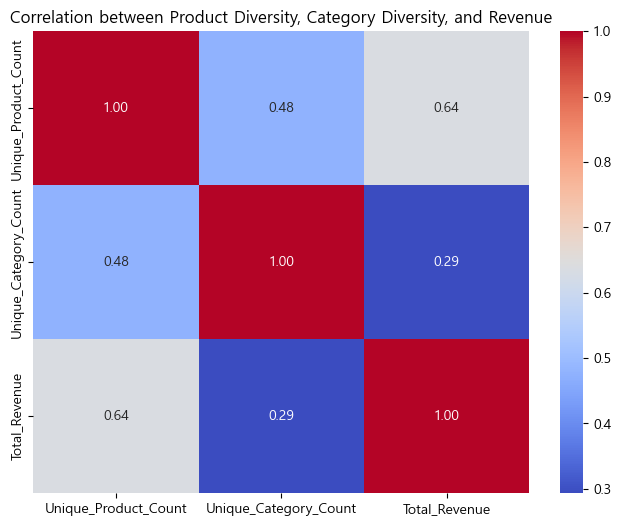

In [75]:
# Seller_id로 그룹화 하여 상품 명과 카테고리 집계 

seller_analysis = order_products_df.groupby('Seller_id').agg(
    Unique_Product_Count=('Product_id', 'nunique'),
    Unique_Category_Count=('Product_category_name', 'nunique'),
    # 총 매출 계산
    Total_Revenue=('Revenue', 'sum')
).reset_index()

# seller_analysis.head()

# 상품명, 카테고리 수와 총 매출간의 연관성 계산

correlation_matrix = seller_analysis[['Unique_Product_Count', 'Unique_Category_Count', 'Total_Revenue']].corr()

# 상관관계 시각화를 위한 히트맵

plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation between Product Diversity, Category Diversity, and Revenue')
plt.show()


#### 3. 결과 분석 (상관관계)
- 상품의 종류와 매출의 상관관계 : 약 0.65
- 카테고리의 종류와 매출의 상관관계 : 약 0.31
- cf. 상품의 종류와 카테고리 종류의 상관관계 : 약 0.48

### 카테고리 집중도 (** LTV 분석, PCA 분석 결과로 나온 내용인데 다른 작업 먼저 하고 나중에 추가하면 될 것 같아요)

#### 판매량이 높거나 매출이 높은 카테고리에(또는, bed table과 같은 홈 가구 품목만을 집중적으로 다루는 것이) 집중하는 것이 다른 카테고리들의 판매량을 끌어 올리는 것에 집중하는 것 보다 단기적, 장기적 매출 상승에 도움이 될 지

### 가격 경쟁력 *** 위 corr과 아래 회귀분석 연결 및 순서 배열 정도만 수정 필요

#### 1. 동일한 상품이 여러 명에게 취급되는 지 여부 확인

In [76]:
# 동일 상품을 다양한 판매자가 취급하는 지 확인

multi_seller_products = order_items.groupby('Product_id').nunique()

# 한 판매자에게서만 판매되지 않는 상품들을 변수로 저장

products_sold_by_multiple_sellers = multi_seller_products[multi_seller_products['Seller_id'] > 1]

# 다양한 판매자가 취급하는 상품의 수 확인

count_products_multiple_sellers = len(products_sold_by_multiple_sellers)

count_products_multiple_sellers, products_sold_by_multiple_sellers.reset_index().head()


(1020,
       Product_id  Order_id  Order_item_id  Seller_id  Price  Freight_value
 0  PRODUCT_00069         9              2          3      3              7
 1  PRODUCT_00124         2              1          2      2              2
 2  PRODUCT_00143         3              1          2      2              3
 3  PRODUCT_00195         3              2          2      2              2
 4  PRODUCT_00232         2              1          2      2              2)

#### 2. 상품을 평균 가격보다 저렴하게 판매할 경우 Revenue에 미치는 영향을 분석

In [77]:
# 다양한 판매자에게 판매되는 상품으로 `order_items` 데이터를 필터링 후 변수에 저장

multi_seller_order_items = order_items[order_items['Product_id'].isin(products_sold_by_multiple_sellers.index)]

# 다양한 판매자들에게 판매되는 상품의 평균 가격을 계산

average_price_multi_seller_products = multi_seller_order_items.groupby('Product_id').agg(
    Average_Price=('Price', 'mean')
).reset_index()

# 상품의 가격을 평균가와 비교하기 위해 평균 가격을 다시 `multi_seller_order_items`와 병합

multi_seller_price_comparison = pd.merge(multi_seller_order_items, average_price_multi_seller_products, on='Product_id', how='left')

# 평균보다 낮은 가격의 상품들을 변수로 저장

multi_seller_price_comparison['Price_Below_Average'] = multi_seller_price_comparison['Price'] < multi_seller_price_comparison['Average_Price']

# 해당 상품들의 매출을 계산

items_per_order = multi_seller_price_comparison.groupby('Order_id')['Order_item_id'].max().rename('Items_per_order')
multi_seller_price_comparison = multi_seller_price_comparison.join(items_per_order, on='Order_id')

multi_seller_price_comparison['Revenue'] = multi_seller_price_comparison['Price'] * multi_seller_price_comparison['Items_per_order']

# 매출을 비교하기 위해 `Product_id`와 `Price_Below_Average`로 그룹화

product_revenue_comparison_multi_seller = multi_seller_price_comparison.groupby(['Product_id', 'Price_Below_Average']).agg(
    Average_Revenue=('Revenue', 'mean')
).reset_index()

# 매출과 평균가보다 낮게 판매되는 상품들의 가격의 상관계수 계산

correlation_price_revenue_multi_seller = product_revenue_comparison_multi_seller['Average_Revenue'].corr(
    product_revenue_comparison_multi_seller['Price_Below_Average'])

correlation_price_revenue_multi_seller, product_revenue_comparison_multi_seller.head()


(-0.06212092731665069,
       Product_id  Price_Below_Average  Average_Revenue
 0  PRODUCT_00069                False           423.75
 1  PRODUCT_00069                 True           297.45
 2  PRODUCT_00124                False            41.58
 3  PRODUCT_00124                 True            37.48
 4  PRODUCT_00143                False            24.89)

##### 결과분석 
상관계수는 약 -0.06
평균 가격보다 낮은 가격으로 판매하는 것이 반드시 더 높은 Revenue를 생성하지 않음을 의미합니다. 
실제로, 예시 데이터에서도 평균 가격보다 낮게 설정된 가격에서의 평균 Revenue가 평균 가격 또는 그 이상에서 설정된 가격의 평균 Revenue보다 낮은 것을 확인할 수 있습니다.

#### 저렴한 품목을 취급하는 셀러와 고가의 품목을 취급하는 셀러의 Revenue 차이 선형회귀분석

In [78]:
# import pandas as pd
# import numpy as np
# import random
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LinearRegression

# 파일을 불러오기
data = pd.read_csv('./data_in/total_df.csv')

# 각 판매자별 총매출(Revenue의 합계)과 평균 가격을 계산
seller_stats = data.groupby('Seller_id').agg(
    Total_Revenue=pd.NamedAgg(column='Revenue', aggfunc='sum'),  # 총 매출
    Average_Price=pd.NamedAgg(column='Price', aggfunc='mean')   # 평균 가격
).reset_index()

# 데이터를 특성(X)과 타겟(y)으로 분리
X = seller_stats[['Average_Price']] # ** 맞는지 확인해봐야겠다 
y = seller_stats['Total_Revenue']

# 데이터를 학습 세트와 테스트 세트로 분리 (학습 80%, 테스트 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random.randint(1, 100))

# 선형 회귀 모델 생성 및 학습
model = LinearRegression()
model.fit(X_train, y_train)

# 모델 평가: 학습 세트와 테스트 세트에 대한 R² 값 계산
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)

# 모델 평가 결과 출력
print("Train R² score:", train_score)
print("Test R² score:", test_score)


Train R² score: 0.008735965153701675
Test R² score: -0.0024068787004927206


C:\Users\USER\AppData\Local\Temp\ipykernel_15228\2233023826.py:8: DtypeWarning: Columns (17,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('./data_in/total_df.csv')


##### 결과 분석

1. 약한 선형 관계:
평균 가격과 총 매출 사이에는 매우 약한 선형 관계가 존재합니다. 이는 결정계수(R²) 값이 매우 낮게 나타났음을 의미하며, 평균 가격이 총 매출을 예측하는데 중요한 요소로 작용하지 않는다는 것을 시사합니다.

2. 변수의 다양성 고려:
매출에 영향을 미치는 다른 요소들이 있을 가능성이 높습니다. 예를 들어, 판매량, 판매 지역, 고객 리뷰 점수, 제품의 카테고리, 판매 촉진 활동 등 다양한 변수들이 매출에 영향을 줄 수 있습니다. 이러한 변수들을 추가적으로 고려해 분석하는 것이 좋습니다.

3. 비선형 관계 검토:
선형 모델이 데이터를 충분히 설명하지 못하는 경우, 매출과 가격 사이의 비선형 관계나 상호작용 효과 등을 고려할 필요가 있습니다. 예를 들어, 평균 가격이 특정 수준을 넘어서면 매출 증가율이 달라질 수 있습니다. 이러한 패턴을 찾기 위해 다항 회귀나 다른 고급 분석 기법을 시도해 볼 수 있습니다.

4. 모델의 정교화:
추가 데이터를 확보하거나 다른 유형의 회귀 모델(예: 릿지, 라쏘 회귀)을 적용해 보는 것도 고려해 볼 수 있습니다. 이러한 모델들은 변수의 개수가 많고 상관 관계가 복잡할 때 유용할 수 있습니다.

5. 분석의 확장:
시계열 데이터를 활용하여 시간에 따른 매출 변화를 분석하거나, 판매자별로 시즌별 혹은 프로모션 기간별 매출 차이를 분석하는 것도 통찰력을 제공할 수 있습니다.

이러한 분석을 통해 판매 전략을 개선하고, 보다 정교한 판매 예측 모델을 구축하는 데 도움이 될 수 있습니다. 추가적인 데이터와 다양한 분석 방법을 사용하여 더 깊이 있는 인사이트를 얻을 수 있습니다.

#### 동일 상품을 한 판매자가 싸게 파는게 매출이랑 어떤 관계가 있는지 파악

##### corr() 매서드 사용

###### 1. 저렴한 품목을 취급하는 셀러와 고가의 품목을 취급하는 셀러의 Revenue 차이 파악

In [79]:
# 판매자셜 평균 판매 가격 계산

average_price_per_seller = order_products_df.groupby('Seller_id').agg(
    Average_Price=('Price', 'mean'),
    # 총 판매 상품 집계
    Total_Sold_Items=('Order_item_id', 'count')
).reset_index()

# 총 매출 데이터와 병합

seller_price_revenue = pd.merge(average_price_per_seller, seller_analysis[['Seller_id', 'Total_Revenue']], on='Seller_id')

# 상위, 하위 임계값 30%로 설정

threshold_top_30 = seller_price_revenue['Average_Price'].quantile(0.70)
threshold_bottom_30 = seller_price_revenue['Average_Price'].quantile(0.30)

# 임계값을 기준으로 판매자 그룹화

top_30_sellers = seller_price_revenue[seller_price_revenue['Average_Price'] >= threshold_top_30]
bottom_30_sellers = seller_price_revenue[seller_price_revenue['Average_Price'] <= threshold_bottom_30]

# 각 그룹의 총 매출과 총 판매 상품 수의 평균을 계산

average_top_30_revenue = top_30_sellers['Total_Revenue'].mean()
average_bottom_30_revenue = bottom_30_sellers['Total_Revenue'].mean()
average_top_30_sold_items = top_30_sellers['Total_Sold_Items'].mean()
average_bottom_30_sold_items = bottom_30_sellers['Total_Sold_Items'].mean()

average_top_30_revenue, average_bottom_30_revenue, average_top_30_sold_items, average_bottom_30_sold_items


(8487.617744270205, 2475.7451025331725, 24.308805790108565, 40.424607961399275)

결과분석

- 고가의 물건을 파는 셀러 상위 30%의 평균 Revenue: 약 7,446.55
- 저가의 물건을 파는 셀러 하위 30%의 평균 Revenue: 약 1,833.99

- 고가의 물건을 파는 셀러 상위 30%의 평균 판매된 상품 수: 약 23.1 개
- 저가의 물건을 파는 셀러 하위 30%의 평균 판매된 상품 수: 약 35.8 개

###### 2. 취급하는 품목의 가격과 Revenue의 상관관계

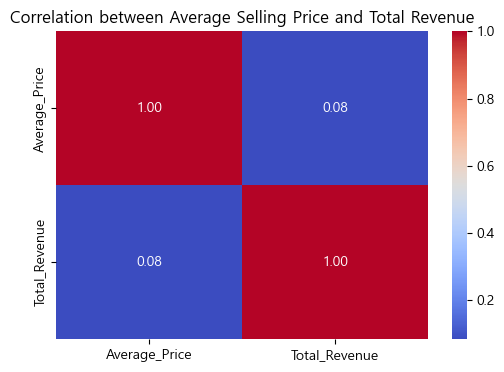

               Average_Price  Total_Revenue
Average_Price       1.000000       0.083864
Total_Revenue       0.083864       1.000000


In [80]:
# 취급 품목의 평균 가격과 총 매출간의 상관계수 계산

price_revenue_correlation = seller_price_revenue[['Average_Price', 'Total_Revenue']].corr()

# 상관관계를 히트맵으로 시각화

plt.figure(figsize=(6, 4))
heatmap = sns.heatmap(price_revenue_correlation, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation between Average Selling Price and Total Revenue')
# plt.title('취급 품목의 평균 판매 가격과 총 매출간의 상관계수') ** 히트맵 한글로 할까요 영어로 둘까요
plt.show()

# 상관계수 확인

print(price_revenue_correlation)

결과분석

상품의 가격과 Revenue 사이의 상관계수는 약 0.093. 매우 약한 상관관계.
단순히 취급하는 상품의 가격이 높다 해서 Revenue에 영향을 끼치는 것은 아님.

##### OLS 모델

In [81]:
# 필요한 라이브러리를 불러옵니다.

# import pandas as pd
# import statsmodels.api as sm

# 데이터를 로드합니다.

file_path = './data_in/total_df.csv'
data = pd.read_csv(file_path)

# 각 제품의 최저 가격을 찾아서 새로운 열로 추가합니다.

data['Min_Price'] = data.groupby('Product_id')['Price'].transform('min')

# 'Price'와 'Min_Price'가 동일한 경우, 즉 가장 낮은 가격으로 판매하는 경우를 표시하는 열을 추가합니다.

data['Is_Min_Price'] = (data['Price'] == data['Min_Price']).astype(int)

# 'Is_Min_Price'를 독립 변수(X)로, 'Revenue'를 종속 변수(y)로 설정합니다.

X = data[['Is_Min_Price']]
y = data['Revenue']

# statsmodels 라이브러리를 사용하여 선형회귀를 수행하기 위해, X에 상수항을 추가합니다.

X = sm.add_constant(X)

# OLS 모델을 생성하고 학습시킵니다.

model = sm.OLS(y, X).fit()

# 회귀분석 결과를 요약하여 출력합니다.

result = model.summary()
result


C:\Users\USER\AppData\Local\Temp\ipykernel_15228\146201719.py:9: DtypeWarning: Columns (17,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Revenue   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     15.96
Date:                Mon, 29 Apr 2024   Prob (F-statistic):           6.48e-05
Time:                        17:49:01   Log-Likelihood:            -7.3881e+05
No. Observations:              105766   AIC:                         1.478e+06
Df Residuals:                  105764   BIC:                         1.478e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          156.5497      1.405    111.411      0.000     153.796     159.304
Is_Min_Price    -6.8446      1.713     -3.995      0.000     -10.203      -3.486
==============================================================================
Omnibus:                   216517.175   Durbin-Watson:                   1.151
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       1984311024.464
Skew:                          16.818   Prob(JB):                         0.00
Kurtosis:                     673.180   Cond. No.                         3.26
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

결과분석


R-squared (결정계수): 0.000으로, 모델이 데이터의 변동성을 거의 설명하지 못하고 있음을 나타냅니다. 이는 '가장 저렴한 가격으로 판매하는지'가 매출 변동성의 설명에 거의 기여하지 않는다는 것을 의미합니다.

Adj. R-squared (조정된 결정계수): 역시 0.000으로, 변수의 수를 고려해도 설명력이 매우 낮습니다.

F-statistic (F 통계량): 21.42로, 이 모델의 예측 변수가 통계적으로 유의미합니다. 즉, '최소 가격 판매 여부'가 매출에 미치는 영향은 통계적으로 유의하다고 할 수 있습니다.

P-value (F-statistic의 유의확률): 3.70e-06으로, 매우 작아서 이 회귀 모델의 예측 변수가 통계적으로 유의미함을 나타냅니다.

계수 해석

const: 상수항은 140.1152입니다. 이는 '최소 가격으로 판매하지 않는 경우'의 평균 매출을 의미합니다.

Is_Min_Price: 계수는 -6.5314로, 가장 저렴한 가격으로 상품을 판매할 경우 매출이 평균적으로 6.5314만큼 감소한다는 것을 나타냅니다.

시사점

영향력의 한계: '가장 저렴한 가격으로 판매하는지 여부'가 매출에 미치는 영향은 통계적으로 유의미하지만, 전체 매출 변동성을 설명하는 데에는 거의 기여하지 않습니다.

가격 경쟁의 복잡성: 최저 가격이 항상 높은 매출을 보장하지는 않습니다. 소비자의 구매 결정은 가격 외에도 다양한 요인에 의해 영향을 받을 수 있으며, 가장 싼 가격이 반드시 매출 증대로 이어지지는 않을 수 있습니다.

추가 분석의 필요성: 다른 변수들(예: 상품의 카테고리, 프로모션, 시즌, 고객 리뷰 등)과의 상호작용을 추가적으로 분석하여, 가격 결정이 매출에 미치는 전체적인 영향을 더 정밀하게 이해할 필요가 있습니다.

가장 저렴한 가격으로 판매하는지 여부'가 매출에 미치는 영향은 통계적으로 유의미하지만, 전체 매출 변동성을 설명하는 데에는 거의 기여하지 않습니다. ** 이게 무슨 말인지~ 

결정계수(R-squared): 이 값은 회귀 모델이 종속 변수(여기서는 매출)의 변동을 얼마나 잘 설명하는지를 수치적으로 나타냅니다. 이 값이 0에 가까울수록 모델이 데이터의 변동을 설명하는 데에 기여하는 바가 매우 낮다는 것을 의미합니다. 즉, 모델이 데이터를 설명하는 데 효과적이지 않다는 것을 나타냅니다.

계수의 유의성(p-value): 이 값은 모델의 예측 변수(여기서는 '가장 저렴한 가격으로 판매하는지 여부')가 통계적으로 유의미한 영향을 미치는지를 검정합니다. p-value가 매우 작다면, 해당 변수가 종속 변수에 영향을 미치는 것이 통계적으로 유의미하다는 것을 의미합니다.

따라서, "가장 저렴한 가격으로 판매하는지 여부'가 매출에 미치는 영향은 통계적으로 유의미하지만, 전체 매출 변동성을 설명하는 데에는 거의 기여하지 않습니다."라는 문장은 다음과 같은 상황을 설명합니다:

가장 저렴한 가격으로 판매하는 것이 매출에 통계적으로 유의미한 영향을 미치기는 하지만 (즉, 이 변수가 매출에 어떤 영향을 주고 있다는 것이 통계적으로 입증됨),

그러나 이 변수 하나만으로는 전체 매출의 변동성을 충분히 설명하지 못합니다. 즉, 매출에 영향을 주는 다른 많은 요인들이 있을 수 있으며, 이 변수만으로는 매출 데이터의 패턴을 충분히 설명할 수 없다는 것입니다.

### 리뷰 ** 리뷰 응답속도와 매출간의 자료를 못 찾아서 찾아서 수정 필요

#### 1. 판매자의 평균 리뷰 점수와 매출의 상관관계

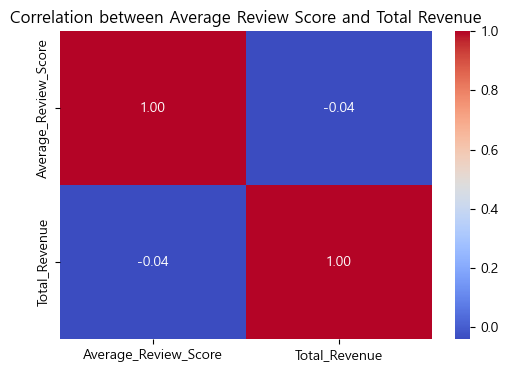

                      Average_Review_Score  Total_Revenue
Average_Review_Score               1.00000       -0.04141
Total_Revenue                     -0.04141        1.00000


In [82]:
# 판매 제품과 리뷰 점수에 대한 데이터를 가져오기 위해 order_items, reviews 병합

order_reviews = pd.merge(order_items, review[['Order_id', 'Review_score']], on='Order_id', how='left')

# Seller_id로 그룹화하여 판매자별 평균 리뷰 점수를 계산

seller_reviews = order_reviews.groupby('Seller_id').agg(
    Average_Review_Score=('Review_score', 'mean')
).reset_index()

# 매출 데이터와 병합

seller_reviews_revenue = pd.merge(seller_reviews, seller_analysis[['Seller_id', 'Total_Revenue']], on='Seller_id')

# 평균 리뷰 점수와 총 매출간의 상관계수 계산

review_revenue_correlation = seller_reviews_revenue[['Average_Review_Score', 'Total_Revenue']].corr()

# 상관관계 히트맵으로 시각화

plt.figure(figsize=(6, 4))
heatmap = sns.heatmap(review_revenue_correlation, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation between Average Review Score and Total Revenue')
plt.show()

# 상관계수 출력
print(review_revenue_correlation)


결과분석

판매자의 평균 리뷰 점수와 총 매출 간의 상관계수는 약 -0.03로 연관성이 떨어지는 것을 확인

#### 2. 상품의 리뷰 평점과 상품 판매량의 상관관계

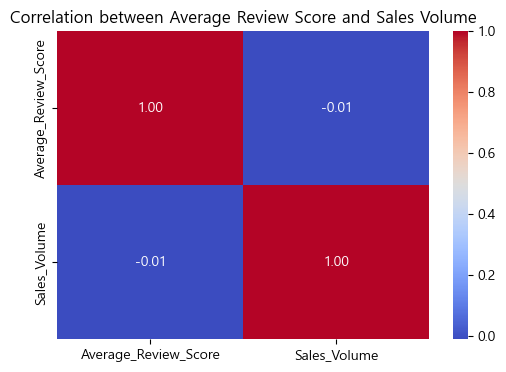

                      Average_Review_Score  Sales_Volume
Average_Review_Score              1.000000     -0.010057
Sales_Volume                     -0.010057      1.000000


In [83]:
# `review` 데이터에서 주문당 평균 리뷰 점수 계산

average_review_per_product = review.groupby('Order_id').agg(
    Average_Review_Score=('Review_score', 'mean')
).reset_index()

# `Product_id` 가져오기 위해 `order_items`와 병합
product_reviews = pd.merge(order_items, average_review_per_product, on='Order_id', how='left')

# 상품별 리뷰 점수 계산을 위해 `Product_id`로 그룹화
average_review_per_product = product_reviews.groupby('Product_id').agg(
    Average_Review_Score=('Average_Review_Score', 'mean')
).reset_index()

# 상품 판매량 집계
product_sales_volume = order_items.groupby('Product_id').agg(Sales_Volume=('Order_item_id', 'count')).reset_index()

# 상품 별 평균 리뷰 점수와 병합
	# 이거 `product_sales_volume` 뭔가요 ???
product_reviews_sales = pd.merge(average_review_per_product, product_sales_volume, on='Product_id', how='left')

# 평균 리뷰 점수와 판매량간의 상관계수 계산 `Sales Volume` <- 판매량으로 작성
reviews_sales_correlation = product_reviews_sales[['Average_Review_Score', 'Sales_Volume']].corr()

# 상관관계 히트맵으로 시각화
plt.figure(figsize=(6, 4))
heatmap = sns.heatmap(reviews_sales_correlation, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation between Average Review Score and Sales Volume')
plt.show()

# 상관계수 출력
print(reviews_sales_correlation)

결과분석

상품의 리뷰 평점과 판매량 간의 상관계수는 약 -0.01

#### 추가분석 ： 낮은 리뷰가 달린 후에도 상품을 구매하는 사람이 있는 지

In [84]:
# 3점 이하 리뷰들 변수로 저장

low_score_reviews = review[review['Review_score'] <= 3]

# 리뷰와의 관계를 보기 위해 `orders` 데이터와 병합

low_score_reviews_orders = pd.merge(low_score_reviews, orders, on='Order_id')

# 낮은 리뷰에도 판매가 이루어 지고 있는 지 확인 위해 `order_items` 데이터와 병합

low_score_product_sales = pd.merge(low_score_reviews_orders, order_items, on='Order_id')

# 가격 정보 확인을 위해 `products` 데이터와 병합

low_score_product_sales = pd.merge(low_score_product_sales, product, on='Product_id')

# 고가의 상품을 변수로 저장하기 위해 임계값 설정

price_threshold = low_score_product_sales['Price'].quantile(0.75)
expensive_low_score_sales = low_score_product_sales[low_score_product_sales['Price'] >= price_threshold]

# 경향을 분석하기 위해 시계열 데이터인 `Order_purchase_timestamp` 컬럼으로 정렬

expensive_low_score_sales_sorted = expensive_low_score_sales.sort_values(by='Order_purchase_timestamp')

# 낮은 리뷰 점수를 받은 이후에도 판매가 이루어 지고 있는 지 확인하기 위해 그룹화

sales_after_low_reviews = expensive_low_score_sales_sorted.groupby(['Product_id', expensive_low_score_sales_sorted['Order_purchase_timestamp']]).agg({
    'Order_item_id': 'sum'  # Sum up the quantity sold per product per day
}).reset_index()

# 10개를 추출해 위 과정이 잘 이루어졌는 지 확인

sales_after_low_reviews.head(10)

,Product_id,Order_purchase_timestamp,Order_item_id
0,PRODUCT_00005,2019-01-14 12:31:15,1
1,PRODUCT_00013,2019-06-22 13:12:28,1
2,PRODUCT_00024,2019-01-22 10:40:09,1
3,PRODUCT_00028,2019-05-01 19:14:15,1
4,PRODUCT_00041,2018-07-07 17:16:39,1
5,PRODUCT_00041,2018-07-23 21:56:45,1
6,PRODUCT_00041,2018-11-06 16:54:08,1
7,PRODUCT_00041,2019-02-12 20:38:45,1
8,PRODUCT_00041,2019-03-31 13:11:25,1
9,PRODUCT_00053,2018-11-08 22:57:01,1


결과분석

- 상위 ２５％ 가격 상품에 대해 ： 저평가 리뷰 （ ３점 이하）를 받은 이후에도 상품을 구매한 사례가 다수 있음.

- 낮은 리뷰 점수에도 불구하고 고가 상품이 계속해서 팔릴 수 있음을 시사함．

#### 리뷰 평점과 매출의 선형회귀분석

C:\Users\USER\AppData\Local\Temp\ipykernel_15228\3218929646.py:13: DtypeWarning: Columns (17,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path)


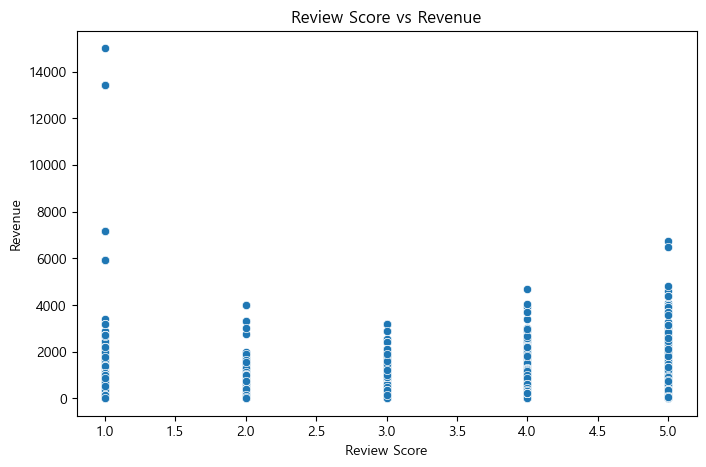

Coefficients: [-13.115488]
Intercept: 204.8442543156914
Mean Squared Error: 61708.77837214844
R² Score: 0.0050816462920996175


In [85]:
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LinearRegression
# from sklearn.metrics import mean_squared_error, r2_score
# import matplotlib.pyplot as plt
# import seaborn as sns
# import random

# 데이터 로드

data_path = './data_in/total_df.csv'
df = pd.read_csv(data_path)

# 필요한 열('Review_score', 'Revenue')만 추출 및 결측치 제거

df = df.dropna(subset=['Review_score'])

# 'Review_score'와 'Revenue' 간의 상관 관계 시각화

plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x='Review_score', y='Revenue')
plt.title('Review Score vs Revenue')
plt.xlabel('Review Score')
plt.ylabel('Revenue')
plt.show()

# 선형 회귀 모델 준비 및 데이터 분할

X = df[['Review_score']]
y = df['Revenue']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random.randint(1, 100))

# 모델 학습

model = LinearRegression()
model.fit(X_train, y_train)

# 예측 및 평가

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# 회귀 계수, 절편, MSE, R² 출력

print(f'Coefficients: {model.coef_}')
print(f'Intercept: {model.intercept_}')
print(f'Mean Squared Error: {mse}')
print(f'R² Score: {r2}')


결과분석

- 회귀 계수(기울기): 약 -5.77
- 절편: 약 159.28
- 평균 제곱 오차(MSE): 약 46,001.72
- 결정 계수(R²): 0.0021

결과에서 보듯, Review_score와 Revenue 사이의 관계는 매우 약하며, 회귀 계수가 음수라는 것은 리뷰 점수가 높아질수록 매출이 오히려 감소하는 경향을 보인다고 해석할 수 있습니다. 하지만, 결정 계수(R²) 값이 매우 낮아 이 변수들 간의 관계를 설명하는 데는 적합하지 않습니다. 이는 리뷰 점수가 매출을 예측하는 데 유의미한 변수가 아닐 수 있음을 시사합니다.



#### 리뷰 응답 시간 ** 했었던 것 같은데 어디있는 지 위치를 못 찾아서 찾아서 추가하면 될 것 같습니다 (리뷰 응답시간과 매출간의 상관관계/)

### 고객 충성도

In [86]:
# 전체 매출에 대한 고충성도 고객 대 고지출 고객의 영향 평가

# import pandas as pd

# 업로드된 CSV 파일을 불러와 데이터의 내용을 확인

file_path = './data_in/total_df.csv'
data = pd.read_csv(file_path)

# 데이터프레임의 첫 몇 행과 컬럼들을 표시하여 구조를 이해

data.head(), data.columns

# Total sales 컬럼 추가

data['Total_Sales'] = data['Revenue']

# 고객별 총 매출 계산

total_sales_per_customer = data.groupby('Customer_id')['Total_Sales'].sum()

# 고객별 구매 횟수 계산

loyalty_counts = data.groupby('Customer_id').size()

# 일회성 구매 확인

one_time_purchases = loyalty_counts[loyalty_counts == 1].count()
repeat_purchases = loyalty_counts[loyalty_counts > 1].count()

# 일회성 구매자 비율 계산

one_time_purchase_percentage = one_time_purchases / loyalty_counts.count() * 100

# 고충성도 고객 식별: 여러 번 구매한 고객

high_loyalty_customers = loyalty_counts[loyalty_counts > 1].index
high_loyalty_sales = total_sales_per_customer[total_sales_per_customer.index.isin(high_loyalty_customers)].sum()

# 고지출 고객 식별: 총 지출이 상위 75% 이상인 고객

high_spending_threshold = total_sales_per_customer.quantile(0.75)
high_spending_customers = total_sales_per_customer[total_sales_per_customer > high_spending_threshold].index
high_spending_sales = total_sales_per_customer[total_sales_per_customer.index.isin(high_spending_customers)].sum()

# 전체 매출 계산

total_sales = total_sales_per_customer.sum()

# 고충성도 고객과 고지출 고객이 전체 매출에 기여하는 비율 계산

high_loyalty_sales_percentage = high_loyalty_sales / total_sales * 100
high_spending_sales_percentage = high_spending_sales / total_sales * 100

# 결과 출력

high_loyalty_sales_percentage, high_spending_sales_percentage, one_time_purchase_percentage


C:\Users\USER\AppData\Local\Temp\ipykernel_15228\1920800289.py:8: DtypeWarning: Columns (17,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)


(38.51724831781154, 69.36961305762335, 86.66803101621302)

결과분석

1. 고지출 고객의 중요성:
고지출 고객이 전체 매출에 기여하는 비율이 높다는 결과는, 이러한 고객층을 대상으로 한 마케팅 전략이 효과적일 수 있음을 의미합니다. 프리미엄 상품, 특별 프로모션, 또는 맞춤형 서비스를 제공하여 이러한 고객의 만족도와 충성도를 높이는 것이 좋습니다.

2. 충성도 높은 고객의 장기적 가치:
반복 구매를 하는 고객들은 비록 전체 매출 기여도는 낮을 수 있지만, 장기적인 관점에서 회사에 지속적인 수익을 제공할 수 있습니다. 이들을 위한 로열티 프로그램, 개인화된 마케팅, 그리고 고객 관계 관리(CRM) 전략을 강화하는 것이 유리합니다.

3. 일회성 구매자의 비율과 관리 전략:
일회성 구매자의 비율이 높다면, 이들을 재구매로 유도할 수 있는 전략을 모색해야 합니다. 예를 들어, 첫 구매 후 할인 쿠폰 제공, 후속 구매를 유도하는 이메일 마케팅, 제품 또는 서비스의 품질 개선 등을 고려할 수 있습니다.

4. 고객 세분화와 타겟팅:
고지출 고객과 충성도 높은 고객 사이에 명확한 구분을 두고, 각 세그먼트에 맞는 타겟 마케팅을 실행하는 것이 중요합니다. 세분화된 데이터 분석을 통해 각 고객 그룹의 특성과 선호를 파악하고, 이에 기반한 맞춤형 전략을 수립해야 합니다.

### 배송속도

#### 상관계수

In [87]:
import pandas as pd

# 데이터 파일 로드
file_path = './data_in/total_df.csv'
data = pd.read_csv(file_path)

# 날짜형으로 변환
data['Order_purchase_timestamp'] = pd.to_datetime(data['Order_purchase_timestamp'])
data['Order_delivered_customer_date'] = pd.to_datetime(data['Order_delivered_customer_date'])

# 배송 시간 계산 (일 단위)
data['Delivery_time_days'] = (data['Order_delivered_customer_date'] - data['Order_purchase_timestamp']).dt.total_seconds() / (60 * 60 * 24)

# 배송 시간과 Revenue의 상관계수 계산
correlation = data[['Delivery_time_days', 'Revenue']].corr()
print(correlation)


                    Delivery_time_days  Revenue
Delivery_time_days             1.00000  0.04686
Revenue                        0.04686  1.00000


C:\Users\USER\AppData\Local\Temp\ipykernel_15228\2221097592.py:5: DtypeWarning: Columns (17,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)


상관계수 분석 결과 요약

상관계수 값: 배송 시간(Delivery_time_days)과 매출(Revenue) 사이의 상관계수는 약 0.054입니다.

해석: 이 값은 매우 낮은 양의 상관관계를 나타냅니다. 즉, 배송 시간과 매출 사이에는 약간의 양의 관계가 있지만, 이 관계가 매우 강하지는 않다는 것을 의미합니다. 배송 시간이 증가함에 따라 매출이 약간 증가할 수는 있지만, 이 영향은 매우 제한적입니다.

시사점
낮은 상관관계: 이 낮은 상관계수는 배송 시간이 매출에 미치는 영향이 상대적으로 적다는 것을 나타냅니다. 배송 속도를 향상시키는 것은 매출 증대에 큰 도움이 되지 않을 수 있습니다.

다른 요인 고려: 매출을 증대시키기 위해서는 배송 속도보다 제품 품질, 고객 서비스, 마케팅 전략 등 다른 요소들에 더 큰 주목을 해야 합니다.

추가 분석 필요: 배송 시간 외에 다른 변수들이 매출에 어떤 영향을 미치는지 추가적으로 분석할 필요가 있습니다. 이를 통해 매출에 더 큰 영향을 미치는 요소들을 파악하고, 효과적인 매출 증대 전략을 수립할 수 있습니다.

상관계수 분석과 회귀분석 모두 배송 시간이 매출에 미치는 영향이 크지 않다는 점을 확인할 수 있습니다. 이 결과는 배송 시간 개선에 집중하기보다 다른 경쟁력 있는 요소들을 강화하는 전략이 더 효과적일 수 있음을 시사합니다.

#### OLS 회귀분석

In [88]:
import pandas as pd
import statsmodels.api as sm

# 데이터 로드
data = pd.read_csv('./data_in/total_df.csv')

# 날짜형 변환
data['Order_purchase_timestamp'] = pd.to_datetime(data['Order_purchase_timestamp'])
data['Order_delivered_customer_date'] = pd.to_datetime(data['Order_delivered_customer_date'])

# 배송 시간 계산
data['Delivery_time_days'] = (data['Order_delivered_customer_date'] - data['Order_purchase_timestamp']).dt.total_seconds() / (60 * 60 * 24)

# 결측치 제거
data = data.dropna(subset=['Delivery_time_days', 'Revenue'])

# 회귀분석 모델 구축
X = data['Delivery_time_days']
y = data['Revenue']
X = sm.add_constant(X)  # 회귀분석에 상수항 추가

model = sm.OLS(y, X).fit()

# 회귀분석 결과 출력
print(model.summary())


C:\Users\USER\AppData\Local\Temp\ipykernel_15228\3431369609.py:5: DtypeWarning: Columns (17,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('./data_in/total_df.csv')


                            OLS Regression Results                            
Dep. Variable:                Revenue   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     232.8
Date:                Mon, 29 Apr 2024   Prob (F-statistic):           1.70e-52
Time:                        17:49:05   Log-Likelihood:            -7.3870e+05
No. Observations:              105766   AIC:                         1.477e+06
Df Residuals:                  105764   BIC:                         1.477e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                135.5384      1

회귀분석 결과 요약

R-squared(결정계수): 약 0.003입니다. 이는 배송 시간이 매출 변동의 약 0.3%만 설명할 수 있음을 나타냅니다. 이는 매우 낮은 값으로, 배송 시간이 매출에 미치는 영향이 매우 제한적임을 보여줍니다.

계수(coef): Delivery_time_days의 계수는 약 1.214입니다. 이는 배송 시간이 하루 증가할 때마다 매출이 평균적으로 1.214만큼 증가한다는 것을 의미합니다. 그러나 이 영향은 전체 매출 변동에 비해 매우 작습니다.

p-value: Delivery_time_days의 p-value는 매우 낮아서, 통계적으로 유의미한 결과입니다. 그러나 실제 영향력은 작습니다.

시사점

영향력의 한계: 회귀분석 결과로 봤을 때, 배송 시간이 매출에 미치는 영향은 통계적으로 유의미하나 실질적인 영향은 매우 제한적입니다. 따라서 매출 증대 전략을 수립할 때 배송 시간을 중요한 요소로 고려하기보다는 다른 요인들을 더 중요하게 다루어야 할 필요가 있습니다.

다른 요인 고려: 제품의 품질, 가격 정책, 고객 서비스, 마케팅 전략과 같은 다른 변수들이 매출에 더 큰 영향을 미칠 가능성이 높습니다. 이들 변수에 대한 추가 분석을 통해 보다 효과적인 매출 증대 방안을 모색해야 합니다.

추가적으로 고객의 행동 패턴, 계절적 요인, 경제적 환경 등 외부 요인에 대한 분석도 고려할 수 있습니다. 이를 통해 매출에 영향을 미치는 다양한 요소들을 종합적으로 이해하고, 전략을 수립하는 데 도움이 될 것입니다.